In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.gaussian_process import GaussianProcessRegressor
from sklearn.gaussian_process.kernels import RBF, ConstantKernel as C, WhiteKernel
from sklearn.metrics import mean_squared_error
from sklearn.preprocessing import StandardScaler
import logging
import random

# Configure logging
logging.basicConfig(level=logging.INFO, format="%(asctime)s - %(levelname)s - %(message)s")

# Define the Active Learning UCB class
class ActiveLearningUCB:
    def __init__(self, kernel=None, alpha=1.0, random_state=42):
        self.alpha = alpha
        self.kernel = kernel if kernel else (
            C(1.0, (1e-5, 1e5)) * RBF(length_scale=1.0, length_scale_bounds=(1e-3, 1e3)) +
            WhiteKernel(noise_level=1e-3, noise_level_bounds=(1e-6, 1e1))
        )
        self.model = GaussianProcessRegressor(kernel=self.kernel, n_restarts_optimizer=10, random_state=random_state)

    def update_model(self, X_train, y_train):
        self.model.fit(X_train, y_train)
        print("Selected kernel after optimization:", self.model.kernel_)

    def ucb_acquisition(self, X_candidates):
        mean, std = self.model.predict(X_candidates, return_std=True)
        return mean + self.alpha * std, mean, std

    def select_next_point(self, X_candidates):
        ucb_scores, mean, std = self.ucb_acquisition(X_candidates)
        return np.argmax(ucb_scores), ucb_scores, mean, std


import numpy as np
from sklearn.gaussian_process import GaussianProcessRegressor
from sklearn.gaussian_process.kernels import RBF, WhiteKernel, ConstantKernel as C
from scipy.stats import norm

class ActiveLearningEI:
    def __init__(self, kernel=None, xi=0.01, random_state=42):
        """
        Active Learning using Expected Improvement (EI) for MAXIMIZATION.
        
        Parameters:
        - kernel: kernel to use in Gaussian Process. Defaults to RBF + WhiteKernel.
        - xi: exploration-exploitation trade-off parameter (default: 0.01)
        - random_state: for reproducibility
        """
        self.xi = xi
        self.kernel = kernel if kernel else (
            C(1.0, (1e-5, 1e5)) * RBF(length_scale=1.0, length_scale_bounds=(1e-3, 1e3)) +
            WhiteKernel(noise_level=1e-3, noise_level_bounds=(1e-6, 1e1))
        )
        self.model = GaussianProcessRegressor(kernel=self.kernel, n_restarts_optimizer=10, random_state=random_state)

    def update_model(self, X_train, y_train):
        self.model.fit(X_train, y_train)
        print("Selected kernel after optimization:", self.model.kernel_)

    def expected_improvement(self, X_candidates, y_best=None):
        mean, std = self.model.predict(X_candidates, return_std=True)
        std = np.maximum(std, 1e-9)  # avoid division by zero

        if y_best is None:
            y_best = np.max(self.model.y_train_)  # Maximization

        improvement = mean - y_best - self.xi  # Flip sign for maximization
        Z = improvement / std
        ei = improvement * norm.cdf(Z) + std * norm.pdf(Z)
        ei[std == 0.0] = 0.0  # No improvement if no uncertainty

        return ei, mean, std

    def select_next_point(self, X_candidates):
        ei, mean, std = self.expected_improvement(X_candidates)
        return np.argmax(ei), ei, mean, std


def run_gpr_experiment_matbench_steels(data_grouped, initial_train_point=1, alpha=1.0, random_seed=42):
    feature_cols =[col for col in data_grouped.columns if col not in ['composition','yield strength','Report', 'Report with output', 'Formatted_Parameters']]
    X = data_grouped[feature_cols].values
    print(X)
    y = data_grouped['yield strength'].values

    scaler = StandardScaler()
    X_normalized = scaler.fit_transform(X)

    max_strength = y.max()

    random.seed(random_seed)
    initial_idx = random.choice(list(range(len(X))))
    X_train = X_normalized[[initial_idx]]
    y_train = np.array([y[initial_idx]])

    model = ActiveLearningUCB(alpha=alpha, random_state=random_seed)
    model.update_model(X_train, y_train)

    selected_indices = [initial_idx]
    iteration_indices = [0]
    selected_strengths = [y[initial_idx]]
    ucb_scores_list = []
    mean_predictions = []
    std_predictions = []
    kernel_params = [str(model.model.kernel_)]

    trajectory_data = [{
        "Iteration": 0,
        "Experiment Index": initial_idx,
        "Observed Yield Strength": y[initial_idx],
        "UCB Score": None,
        "Mean Prediction": None,
        "Standard Deviation": None,
        "Kernel Parameters": str(model.model.kernel_),
        "Max Yield Strength in Dataset": max_strength,
        "Stopping Reason": "Initial selection"
    }]

    for i in range(len(X) - 1):
        available_indices = [j for j in range(len(X)) if j not in selected_indices]
        if not available_indices:
            break

        X_candidates = X_normalized[available_indices]
        next_local_idx, ucb_scores, means, stds = model.select_next_point(X_candidates)
        next_idx = available_indices[next_local_idx]

        selected_indices.append(next_idx)
        X_train = np.vstack([X_train, X_normalized[[next_idx]]])
        y_train = np.append(y_train, y[next_idx])

        model.update_model(X_train, y_train)

        iteration_indices.append(i + 1)
        selected_strengths.append(y[next_idx])
        ucb_scores_list.append(ucb_scores[next_local_idx])
        mean_predictions.append(means[next_local_idx])
        std_predictions.append(stds[next_local_idx])
        kernel_params.append(str(model.model.kernel_))

        trajectory_data.append({
            "Iteration": i + 1,
            "Experiment Index": next_idx,
            "Observed Yield Strength": y[next_idx],
            "UCB Score": ucb_scores[next_local_idx],
            "Mean Prediction": means[next_local_idx],
            "Standard Deviation": stds[next_local_idx],
            "Kernel Parameters": str(model.model.kernel_),
            "Max Yield Strength in Dataset": max_strength,
            "Stopping Reason": "Max yield strength reached" if y[next_idx] >= max_strength else "Continuing"
        })

        if y[next_idx] >= max_strength:
            print(f"Stopping early at iteration {i+1} - Max yield strength found.")
            break

    trajectory_df = pd.DataFrame(trajectory_data)
    #filename = f"al_trajectory_data_matbench_steels/gpr_experiment_trajectory_matbench_steels_alpha{alpha}_seed{random_seed}.csv"
    trajectory_df.to_csv(r"C:\Users\rafae\OneDrive\Imágenes\Documentos\PhDToronto\HongChenProject\results.csv", index=False)
    print(f"Saved trajectory data")



    plt.figure(figsize=(8, 5))
    plt.plot(iteration_indices, selected_strengths, marker='o', linestyle='-', label="Observed Strength")
    plt.fill_between(iteration_indices[1:],
                     np.array(mean_predictions) - np.array(std_predictions),
                     np.array(mean_predictions) + np.array(std_predictions),
                     color="gray", alpha=0.3, label="Uncertainty")
    plt.plot(iteration_indices[1:], mean_predictions, linestyle='--', color="blue", label="Predicted Strength")
    plt.scatter(iteration_indices[1:], ucb_scores_list, marker='s', color="orange", label=f"UCB Score (alpha={alpha})")
    plt.axhline(y=max_strength, color='r', linestyle='--', label='Max Yield Strength')
    plt.xlabel("Iteration")
    plt.ylabel("Yield Strength")
    plt.title(f"GPR Active Learning on matbench_steels (Seed={random_seed}, Alpha={alpha})")
    plt.legend()
    plt.grid(True)
    plt.tight_layout()
    plt.show()



[[7.68e-01 9.31e-04 2.44e-03 ... 2.69e-03 0.00e+00 0.00e+00]
 [6.48e-01 7.51e-03 1.03e-04 ... 0.00e+00 2.01e-03 0.00e+00]
 [6.77e-01 9.16e-03 1.00e-04 ... 0.00e+00 0.00e+00 0.00e+00]
 ...
 [6.99e-01 9.46e-04 1.03e-04 ... 4.87e-03 0.00e+00 0.00e+00]
 [7.98e-01 4.69e-04 8.20e-04 ... 2.35e-03 0.00e+00 0.00e+00]
 [6.96e-01 9.25e-03 1.01e-04 ... 0.00e+00 0.00e+00 0.00e+00]]
Selected kernel after optimization: 316**2 * RBF(length_scale=1) + WhiteKernel(noise_level=10)
Selected kernel after optimization: 316**2 * RBF(length_scale=1e+03) + WhiteKernel(noise_level=7.41)
Selected kernel after optimization: 316**2 * RBF(length_scale=24.5) + WhiteKernel(noise_level=1.34e-05)


C:\Users\rafae\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\gaussian_process\kernels.py:452: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__k1__constant_value is close to the specified upper bound 100000.0. Increasing the bound and calling fit again may find a better value.
  warnings.warn(
C:\Users\rafae\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\gaussian_process\kernels.py:452: ConvergenceWarning: The optimal value found for dimension 0 of parameter k2__noise_level is close to the specified upper bound 10.0. Increasing the bound and calling fit again may find a better value.
  warnings.warn(
C:\Users\rafae\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\gaussian_process\kernels.py:452: ConvergenceWa

Selected kernel after optimization: 316**2 * RBF(length_scale=15.8) + WhiteKernel(noise_level=5.89e-05)
Selected kernel after optimization: 316**2 * RBF(length_scale=1.75) + WhiteKernel(noise_level=10)
Selected kernel after optimization: 316**2 * RBF(length_scale=0.156) + WhiteKernel(noise_level=10)
Selected kernel after optimization: 316**2 * RBF(length_scale=2.12) + WhiteKernel(noise_level=10)
Selected kernel after optimization: 316**2 * RBF(length_scale=2.2) + WhiteKernel(noise_level=10)
Selected kernel after optimization: 316**2 * RBF(length_scale=2.23) + WhiteKernel(noise_level=10)


C:\Users\rafae\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\gaussian_process\kernels.py:452: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__k1__constant_value is close to the specified upper bound 100000.0. Increasing the bound and calling fit again may find a better value.
  warnings.warn(
C:\Users\rafae\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\gaussian_process\kernels.py:452: ConvergenceWarning: The optimal value found for dimension 0 of parameter k2__noise_level is close to the specified upper bound 10.0. Increasing the bound and calling fit again may find a better value.
  warnings.warn(
C:\Users\rafae\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\gaussian_process\kernels.py:452: ConvergenceWa

Selected kernel after optimization: 316**2 * RBF(length_scale=2.19) + WhiteKernel(noise_level=10)
Selected kernel after optimization: 316**2 * RBF(length_scale=2.01) + WhiteKernel(noise_level=10)
Selected kernel after optimization: 316**2 * RBF(length_scale=0.0341) + WhiteKernel(noise_level=10)
Selected kernel after optimization: 316**2 * RBF(length_scale=2.29) + WhiteKernel(noise_level=10)


C:\Users\rafae\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\gaussian_process\kernels.py:452: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__k1__constant_value is close to the specified upper bound 100000.0. Increasing the bound and calling fit again may find a better value.
  warnings.warn(
C:\Users\rafae\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\gaussian_process\kernels.py:452: ConvergenceWarning: The optimal value found for dimension 0 of parameter k2__noise_level is close to the specified upper bound 10.0. Increasing the bound and calling fit again may find a better value.
  warnings.warn(
C:\Users\rafae\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\gaussian_process\kernels.py:452: ConvergenceWa

Selected kernel after optimization: 316**2 * RBF(length_scale=2.02) + WhiteKernel(noise_level=10)
Selected kernel after optimization: 316**2 * RBF(length_scale=2.02) + WhiteKernel(noise_level=10)
Selected kernel after optimization: 316**2 * RBF(length_scale=2.08) + WhiteKernel(noise_level=10)


C:\Users\rafae\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\gaussian_process\kernels.py:452: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__k1__constant_value is close to the specified upper bound 100000.0. Increasing the bound and calling fit again may find a better value.
  warnings.warn(
C:\Users\rafae\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\gaussian_process\kernels.py:452: ConvergenceWarning: The optimal value found for dimension 0 of parameter k2__noise_level is close to the specified upper bound 10.0. Increasing the bound and calling fit again may find a better value.
  warnings.warn(
C:\Users\rafae\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\gaussian_process\kernels.py:452: ConvergenceWa

Selected kernel after optimization: 316**2 * RBF(length_scale=2.1) + WhiteKernel(noise_level=10)
Selected kernel after optimization: 316**2 * RBF(length_scale=1.92) + WhiteKernel(noise_level=10)
Selected kernel after optimization: 316**2 * RBF(length_scale=1.96) + WhiteKernel(noise_level=10)


C:\Users\rafae\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\gaussian_process\kernels.py:452: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__k1__constant_value is close to the specified upper bound 100000.0. Increasing the bound and calling fit again may find a better value.
  warnings.warn(
C:\Users\rafae\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\gaussian_process\kernels.py:452: ConvergenceWarning: The optimal value found for dimension 0 of parameter k2__noise_level is close to the specified upper bound 10.0. Increasing the bound and calling fit again may find a better value.
  warnings.warn(
C:\Users\rafae\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\gaussian_process\kernels.py:452: ConvergenceWa

Selected kernel after optimization: 316**2 * RBF(length_scale=1.89) + WhiteKernel(noise_level=10)
Selected kernel after optimization: 316**2 * RBF(length_scale=1.9) + WhiteKernel(noise_level=10)
Selected kernel after optimization: 316**2 * RBF(length_scale=1.94) + WhiteKernel(noise_level=10)


C:\Users\rafae\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\gaussian_process\kernels.py:452: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__k1__constant_value is close to the specified upper bound 100000.0. Increasing the bound and calling fit again may find a better value.
  warnings.warn(
C:\Users\rafae\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\gaussian_process\kernels.py:452: ConvergenceWarning: The optimal value found for dimension 0 of parameter k2__noise_level is close to the specified upper bound 10.0. Increasing the bound and calling fit again may find a better value.
  warnings.warn(
C:\Users\rafae\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\gaussian_process\kernels.py:452: ConvergenceWa

Selected kernel after optimization: 316**2 * RBF(length_scale=1.43) + WhiteKernel(noise_level=10)
Selected kernel after optimization: 316**2 * RBF(length_scale=1.4) + WhiteKernel(noise_level=10)


C:\Users\rafae\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\gaussian_process\kernels.py:452: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__k1__constant_value is close to the specified upper bound 100000.0. Increasing the bound and calling fit again may find a better value.
  warnings.warn(
C:\Users\rafae\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\gaussian_process\kernels.py:452: ConvergenceWarning: The optimal value found for dimension 0 of parameter k2__noise_level is close to the specified upper bound 10.0. Increasing the bound and calling fit again may find a better value.
  warnings.warn(
C:\Users\rafae\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\gaussian_process\kernels.py:452: ConvergenceWa

Selected kernel after optimization: 316**2 * RBF(length_scale=1.14) + WhiteKernel(noise_level=10)
Selected kernel after optimization: 316**2 * RBF(length_scale=1.15) + WhiteKernel(noise_level=10)


C:\Users\rafae\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\gaussian_process\kernels.py:452: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__k1__constant_value is close to the specified upper bound 100000.0. Increasing the bound and calling fit again may find a better value.
  warnings.warn(
C:\Users\rafae\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\gaussian_process\kernels.py:452: ConvergenceWarning: The optimal value found for dimension 0 of parameter k2__noise_level is close to the specified upper bound 10.0. Increasing the bound and calling fit again may find a better value.
  warnings.warn(
C:\Users\rafae\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\gaussian_process\kernels.py:452: ConvergenceWa

Selected kernel after optimization: 316**2 * RBF(length_scale=1.1) + WhiteKernel(noise_level=10)
Selected kernel after optimization: 316**2 * RBF(length_scale=1.11) + WhiteKernel(noise_level=10)
Selected kernel after optimization: 316**2 * RBF(length_scale=1.11) + WhiteKernel(noise_level=10)
Selected kernel after optimization: 316**2 * RBF(length_scale=1.12) + WhiteKernel(noise_level=10)


C:\Users\rafae\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\gaussian_process\kernels.py:452: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__k1__constant_value is close to the specified upper bound 100000.0. Increasing the bound and calling fit again may find a better value.
  warnings.warn(
C:\Users\rafae\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\gaussian_process\kernels.py:452: ConvergenceWarning: The optimal value found for dimension 0 of parameter k2__noise_level is close to the specified upper bound 10.0. Increasing the bound and calling fit again may find a better value.
  warnings.warn(
C:\Users\rafae\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\gaussian_process\kernels.py:452: ConvergenceWa

Selected kernel after optimization: 316**2 * RBF(length_scale=1.11) + WhiteKernel(noise_level=10)
Selected kernel after optimization: 316**2 * RBF(length_scale=1.11) + WhiteKernel(noise_level=10)


C:\Users\rafae\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\gaussian_process\kernels.py:452: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__k1__constant_value is close to the specified upper bound 100000.0. Increasing the bound and calling fit again may find a better value.
  warnings.warn(
C:\Users\rafae\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\gaussian_process\kernels.py:452: ConvergenceWarning: The optimal value found for dimension 0 of parameter k2__noise_level is close to the specified upper bound 10.0. Increasing the bound and calling fit again may find a better value.
  warnings.warn(
C:\Users\rafae\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\gaussian_process\kernels.py:452: ConvergenceWa

Selected kernel after optimization: 316**2 * RBF(length_scale=1.08) + WhiteKernel(noise_level=10)
Selected kernel after optimization: 316**2 * RBF(length_scale=1.08) + WhiteKernel(noise_level=10)


C:\Users\rafae\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\gaussian_process\kernels.py:452: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__k1__constant_value is close to the specified upper bound 100000.0. Increasing the bound and calling fit again may find a better value.
  warnings.warn(
C:\Users\rafae\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\gaussian_process\kernels.py:452: ConvergenceWarning: The optimal value found for dimension 0 of parameter k2__noise_level is close to the specified upper bound 10.0. Increasing the bound and calling fit again may find a better value.
  warnings.warn(
C:\Users\rafae\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\gaussian_process\kernels.py:452: ConvergenceWa

Selected kernel after optimization: 316**2 * RBF(length_scale=1.08) + WhiteKernel(noise_level=10)
Selected kernel after optimization: 316**2 * RBF(length_scale=1.07) + WhiteKernel(noise_level=1.88e-05)


C:\Users\rafae\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\gaussian_process\kernels.py:452: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__k1__constant_value is close to the specified upper bound 100000.0. Increasing the bound and calling fit again may find a better value.
  warnings.warn(
C:\Users\rafae\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\gaussian_process\kernels.py:452: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__k1__constant_value is close to the specified upper bound 100000.0. Increasing the bound and calling fit again may find a better value.
  warnings.warn(
C:\Users\rafae\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\gaussian_process\kernels.py:452: Co

Selected kernel after optimization: 316**2 * RBF(length_scale=1) + WhiteKernel(noise_level=1.88e-05)
Selected kernel after optimization: 316**2 * RBF(length_scale=0.97) + WhiteKernel(noise_level=1.88e-05)
Selected kernel after optimization: 316**2 * RBF(length_scale=0.969) + WhiteKernel(noise_level=1.88e-05)


C:\Users\rafae\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\gaussian_process\kernels.py:452: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__k1__constant_value is close to the specified upper bound 100000.0. Increasing the bound and calling fit again may find a better value.
  warnings.warn(
C:\Users\rafae\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\gaussian_process\kernels.py:452: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__k1__constant_value is close to the specified upper bound 100000.0. Increasing the bound and calling fit again may find a better value.
  warnings.warn(
C:\Users\rafae\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\gaussian_process\kernels.py:452: Co

Selected kernel after optimization: 316**2 * RBF(length_scale=0.976) + WhiteKernel(noise_level=1.88e-05)
Selected kernel after optimization: 316**2 * RBF(length_scale=0.973) + WhiteKernel(noise_level=1.88e-05)
Selected kernel after optimization: 316**2 * RBF(length_scale=0.952) + WhiteKernel(noise_level=1.88e-05)


C:\Users\rafae\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\gaussian_process\kernels.py:452: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__k1__constant_value is close to the specified upper bound 100000.0. Increasing the bound and calling fit again may find a better value.
  warnings.warn(
C:\Users\rafae\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\gaussian_process\kernels.py:452: ConvergenceWarning: The optimal value found for dimension 0 of parameter k2__noise_level is close to the specified upper bound 10.0. Increasing the bound and calling fit again may find a better value.
  warnings.warn(
C:\Users\rafae\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\gaussian_process\kernels.py:452: ConvergenceWa

Selected kernel after optimization: 316**2 * RBF(length_scale=0.971) + WhiteKernel(noise_level=10)
Selected kernel after optimization: 316**2 * RBF(length_scale=0.929) + WhiteKernel(noise_level=1.88e-05)
Selected kernel after optimization: 316**2 * RBF(length_scale=0.943) + WhiteKernel(noise_level=10)


C:\Users\rafae\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\gaussian_process\kernels.py:452: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__k1__constant_value is close to the specified upper bound 100000.0. Increasing the bound and calling fit again may find a better value.
  warnings.warn(
C:\Users\rafae\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\gaussian_process\kernels.py:452: ConvergenceWarning: The optimal value found for dimension 0 of parameter k2__noise_level is close to the specified upper bound 10.0. Increasing the bound and calling fit again may find a better value.
  warnings.warn(
C:\Users\rafae\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\gaussian_process\kernels.py:452: ConvergenceWa

Selected kernel after optimization: 316**2 * RBF(length_scale=0.951) + WhiteKernel(noise_level=10)
Selected kernel after optimization: 316**2 * RBF(length_scale=0.955) + WhiteKernel(noise_level=10)


C:\Users\rafae\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\gaussian_process\kernels.py:452: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__k1__constant_value is close to the specified upper bound 100000.0. Increasing the bound and calling fit again may find a better value.
  warnings.warn(
C:\Users\rafae\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\gaussian_process\kernels.py:452: ConvergenceWarning: The optimal value found for dimension 0 of parameter k2__noise_level is close to the specified upper bound 10.0. Increasing the bound and calling fit again may find a better value.
  warnings.warn(
C:\Users\rafae\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\gaussian_process\kernels.py:452: ConvergenceWa

Selected kernel after optimization: 316**2 * RBF(length_scale=0.962) + WhiteKernel(noise_level=10)


C:\Users\rafae\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\gaussian_process\kernels.py:452: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__k1__constant_value is close to the specified upper bound 100000.0. Increasing the bound and calling fit again may find a better value.
  warnings.warn(
C:\Users\rafae\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\gaussian_process\kernels.py:452: ConvergenceWarning: The optimal value found for dimension 0 of parameter k2__noise_level is close to the specified upper bound 10.0. Increasing the bound and calling fit again may find a better value.
  warnings.warn(
C:\Users\rafae\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\gaussian_process\kernels.py:452: ConvergenceWa

Selected kernel after optimization: 316**2 * RBF(length_scale=0.958) + WhiteKernel(noise_level=10)
Selected kernel after optimization: 316**2 * RBF(length_scale=0.955) + WhiteKernel(noise_level=10)


C:\Users\rafae\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\gaussian_process\kernels.py:452: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__k1__constant_value is close to the specified upper bound 100000.0. Increasing the bound and calling fit again may find a better value.
  warnings.warn(
C:\Users\rafae\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\gaussian_process\kernels.py:452: ConvergenceWarning: The optimal value found for dimension 0 of parameter k2__noise_level is close to the specified upper bound 10.0. Increasing the bound and calling fit again may find a better value.
  warnings.warn(
C:\Users\rafae\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\gaussian_process\kernels.py:452: ConvergenceWa

Selected kernel after optimization: 316**2 * RBF(length_scale=0.95) + WhiteKernel(noise_level=10)
Selected kernel after optimization: 316**2 * RBF(length_scale=0.944) + WhiteKernel(noise_level=1.88e-05)


C:\Users\rafae\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\gaussian_process\kernels.py:452: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__k1__constant_value is close to the specified upper bound 100000.0. Increasing the bound and calling fit again may find a better value.
  warnings.warn(
C:\Users\rafae\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\gaussian_process\kernels.py:452: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__k1__constant_value is close to the specified upper bound 100000.0. Increasing the bound and calling fit again may find a better value.
  warnings.warn(
C:\Users\rafae\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\gaussian_process\kernels.py:452: Co

Selected kernel after optimization: 316**2 * RBF(length_scale=0.942) + WhiteKernel(noise_level=1.88e-05)
Selected kernel after optimization: 316**2 * RBF(length_scale=0.946) + WhiteKernel(noise_level=10)


C:\Users\rafae\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\gaussian_process\kernels.py:452: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__k1__constant_value is close to the specified upper bound 100000.0. Increasing the bound and calling fit again may find a better value.
  warnings.warn(
C:\Users\rafae\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\gaussian_process\kernels.py:452: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__k1__constant_value is close to the specified upper bound 100000.0. Increasing the bound and calling fit again may find a better value.
  warnings.warn(
C:\Users\rafae\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\gaussian_process\kernels.py:452: Co

Selected kernel after optimization: 316**2 * RBF(length_scale=0.936) + WhiteKernel(noise_level=1.88e-05)
Selected kernel after optimization: 316**2 * RBF(length_scale=0.96) + WhiteKernel(noise_level=10)


C:\Users\rafae\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\gaussian_process\kernels.py:452: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__k1__constant_value is close to the specified upper bound 100000.0. Increasing the bound and calling fit again may find a better value.
  warnings.warn(
C:\Users\rafae\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\gaussian_process\kernels.py:452: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__k1__constant_value is close to the specified upper bound 100000.0. Increasing the bound and calling fit again may find a better value.
  warnings.warn(


Selected kernel after optimization: 316**2 * RBF(length_scale=0.951) + WhiteKernel(noise_level=1.88e-05)
Selected kernel after optimization: 316**2 * RBF(length_scale=0.951) + WhiteKernel(noise_level=1.88e-05)


C:\Users\rafae\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\gaussian_process\kernels.py:452: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__k1__constant_value is close to the specified upper bound 100000.0. Increasing the bound and calling fit again may find a better value.
  warnings.warn(
C:\Users\rafae\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\gaussian_process\kernels.py:452: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__k1__constant_value is close to the specified upper bound 100000.0. Increasing the bound and calling fit again may find a better value.
  warnings.warn(


Selected kernel after optimization: 316**2 * RBF(length_scale=0.953) + WhiteKernel(noise_level=1.88e-05)
Selected kernel after optimization: 316**2 * RBF(length_scale=0.962) + WhiteKernel(noise_level=1.88e-05)


C:\Users\rafae\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\gaussian_process\kernels.py:452: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__k1__constant_value is close to the specified upper bound 100000.0. Increasing the bound and calling fit again may find a better value.
  warnings.warn(
C:\Users\rafae\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\gaussian_process\kernels.py:452: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__k1__constant_value is close to the specified upper bound 100000.0. Increasing the bound and calling fit again may find a better value.
  warnings.warn(


Selected kernel after optimization: 316**2 * RBF(length_scale=0.958) + WhiteKernel(noise_level=1.88e-05)
Selected kernel after optimization: 316**2 * RBF(length_scale=0.949) + WhiteKernel(noise_level=1.88e-05)


C:\Users\rafae\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\gaussian_process\kernels.py:452: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__k1__constant_value is close to the specified upper bound 100000.0. Increasing the bound and calling fit again may find a better value.
  warnings.warn(
C:\Users\rafae\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\gaussian_process\kernels.py:452: ConvergenceWarning: The optimal value found for dimension 0 of parameter k2__noise_level is close to the specified upper bound 10.0. Increasing the bound and calling fit again may find a better value.
  warnings.warn(
C:\Users\rafae\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\gaussian_process\kernels.py:452: ConvergenceWa

Selected kernel after optimization: 316**2 * RBF(length_scale=0.941) + WhiteKernel(noise_level=10)
Selected kernel after optimization: 316**2 * RBF(length_scale=0.929) + WhiteKernel(noise_level=10)


C:\Users\rafae\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\gaussian_process\kernels.py:452: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__k1__constant_value is close to the specified upper bound 100000.0. Increasing the bound and calling fit again may find a better value.
  warnings.warn(
C:\Users\rafae\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\gaussian_process\kernels.py:452: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__k1__constant_value is close to the specified upper bound 100000.0. Increasing the bound and calling fit again may find a better value.
  warnings.warn(


Selected kernel after optimization: 316**2 * RBF(length_scale=0.916) + WhiteKernel(noise_level=1.88e-05)
Selected kernel after optimization: 316**2 * RBF(length_scale=0.918) + WhiteKernel(noise_level=1.88e-05)


C:\Users\rafae\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\gaussian_process\kernels.py:452: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__k1__constant_value is close to the specified upper bound 100000.0. Increasing the bound and calling fit again may find a better value.
  warnings.warn(
C:\Users\rafae\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\gaussian_process\kernels.py:452: ConvergenceWarning: The optimal value found for dimension 0 of parameter k2__noise_level is close to the specified upper bound 10.0. Increasing the bound and calling fit again may find a better value.
  warnings.warn(
C:\Users\rafae\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\gaussian_process\kernels.py:452: ConvergenceWa

Selected kernel after optimization: 316**2 * RBF(length_scale=0.933) + WhiteKernel(noise_level=10)
Selected kernel after optimization: 316**2 * RBF(length_scale=0.885) + WhiteKernel(noise_level=10)


C:\Users\rafae\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\gaussian_process\kernels.py:452: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__k1__constant_value is close to the specified upper bound 100000.0. Increasing the bound and calling fit again may find a better value.
  warnings.warn(
C:\Users\rafae\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\gaussian_process\kernels.py:452: ConvergenceWarning: The optimal value found for dimension 0 of parameter k2__noise_level is close to the specified upper bound 10.0. Increasing the bound and calling fit again may find a better value.
  warnings.warn(
C:\Users\rafae\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\gaussian_process\kernels.py:452: ConvergenceWa

Selected kernel after optimization: 316**2 * RBF(length_scale=0.888) + WhiteKernel(noise_level=10)
Selected kernel after optimization: 316**2 * RBF(length_scale=0.89) + WhiteKernel(noise_level=10)


C:\Users\rafae\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\gaussian_process\kernels.py:452: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__k1__constant_value is close to the specified upper bound 100000.0. Increasing the bound and calling fit again may find a better value.
  warnings.warn(
C:\Users\rafae\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\gaussian_process\kernels.py:452: ConvergenceWarning: The optimal value found for dimension 0 of parameter k2__noise_level is close to the specified upper bound 10.0. Increasing the bound and calling fit again may find a better value.
  warnings.warn(
C:\Users\rafae\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\gaussian_process\kernels.py:452: ConvergenceWa

Selected kernel after optimization: 316**2 * RBF(length_scale=0.892) + WhiteKernel(noise_level=10)
Selected kernel after optimization: 316**2 * RBF(length_scale=0.849) + WhiteKernel(noise_level=10)


C:\Users\rafae\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\gaussian_process\kernels.py:452: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__k1__constant_value is close to the specified upper bound 100000.0. Increasing the bound and calling fit again may find a better value.
  warnings.warn(
C:\Users\rafae\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\gaussian_process\kernels.py:452: ConvergenceWarning: The optimal value found for dimension 0 of parameter k2__noise_level is close to the specified upper bound 10.0. Increasing the bound and calling fit again may find a better value.
  warnings.warn(
C:\Users\rafae\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\gaussian_process\kernels.py:452: ConvergenceWa

Selected kernel after optimization: 316**2 * RBF(length_scale=0.854) + WhiteKernel(noise_level=10)
Selected kernel after optimization: 316**2 * RBF(length_scale=0.841) + WhiteKernel(noise_level=10)


C:\Users\rafae\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\gaussian_process\kernels.py:452: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__k1__constant_value is close to the specified upper bound 100000.0. Increasing the bound and calling fit again may find a better value.
  warnings.warn(
C:\Users\rafae\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\gaussian_process\kernels.py:452: ConvergenceWarning: The optimal value found for dimension 0 of parameter k2__noise_level is close to the specified upper bound 10.0. Increasing the bound and calling fit again may find a better value.
  warnings.warn(
C:\Users\rafae\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\gaussian_process\kernels.py:452: ConvergenceWa

Selected kernel after optimization: 316**2 * RBF(length_scale=0.844) + WhiteKernel(noise_level=10)
Selected kernel after optimization: 316**2 * RBF(length_scale=0.847) + WhiteKernel(noise_level=10)


C:\Users\rafae\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\gaussian_process\kernels.py:452: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__k1__constant_value is close to the specified upper bound 100000.0. Increasing the bound and calling fit again may find a better value.
  warnings.warn(
C:\Users\rafae\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\gaussian_process\kernels.py:452: ConvergenceWarning: The optimal value found for dimension 0 of parameter k2__noise_level is close to the specified upper bound 10.0. Increasing the bound and calling fit again may find a better value.
  warnings.warn(
C:\Users\rafae\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\gaussian_process\kernels.py:452: ConvergenceWa

Selected kernel after optimization: 316**2 * RBF(length_scale=0.851) + WhiteKernel(noise_level=10)
Selected kernel after optimization: 316**2 * RBF(length_scale=0.848) + WhiteKernel(noise_level=10)


C:\Users\rafae\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\gaussian_process\kernels.py:452: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__k1__constant_value is close to the specified upper bound 100000.0. Increasing the bound and calling fit again may find a better value.
  warnings.warn(
C:\Users\rafae\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\gaussian_process\kernels.py:452: ConvergenceWarning: The optimal value found for dimension 0 of parameter k2__noise_level is close to the specified upper bound 10.0. Increasing the bound and calling fit again may find a better value.
  warnings.warn(
C:\Users\rafae\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\gaussian_process\kernels.py:452: ConvergenceWa

Selected kernel after optimization: 316**2 * RBF(length_scale=0.841) + WhiteKernel(noise_level=10)
Selected kernel after optimization: 316**2 * RBF(length_scale=0.842) + WhiteKernel(noise_level=10)


C:\Users\rafae\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\gaussian_process\kernels.py:452: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__k1__constant_value is close to the specified upper bound 100000.0. Increasing the bound and calling fit again may find a better value.
  warnings.warn(
C:\Users\rafae\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\gaussian_process\kernels.py:452: ConvergenceWarning: The optimal value found for dimension 0 of parameter k2__noise_level is close to the specified upper bound 10.0. Increasing the bound and calling fit again may find a better value.
  warnings.warn(


Selected kernel after optimization: 316**2 * RBF(length_scale=0.844) + WhiteKernel(noise_level=10)


C:\Users\rafae\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\gaussian_process\kernels.py:452: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__k1__constant_value is close to the specified upper bound 100000.0. Increasing the bound and calling fit again may find a better value.
  warnings.warn(
C:\Users\rafae\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\gaussian_process\kernels.py:452: ConvergenceWarning: The optimal value found for dimension 0 of parameter k2__noise_level is close to the specified upper bound 10.0. Increasing the bound and calling fit again may find a better value.
  warnings.warn(


Selected kernel after optimization: 316**2 * RBF(length_scale=0.843) + WhiteKernel(noise_level=10)


C:\Users\rafae\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\gaussian_process\kernels.py:452: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__k1__constant_value is close to the specified upper bound 100000.0. Increasing the bound and calling fit again may find a better value.
  warnings.warn(
C:\Users\rafae\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\gaussian_process\kernels.py:452: ConvergenceWarning: The optimal value found for dimension 0 of parameter k2__noise_level is close to the specified upper bound 10.0. Increasing the bound and calling fit again may find a better value.
  warnings.warn(


Selected kernel after optimization: 316**2 * RBF(length_scale=0.843) + WhiteKernel(noise_level=10)


C:\Users\rafae\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\gaussian_process\kernels.py:452: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__k1__constant_value is close to the specified upper bound 100000.0. Increasing the bound and calling fit again may find a better value.
  warnings.warn(
C:\Users\rafae\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\gaussian_process\kernels.py:452: ConvergenceWarning: The optimal value found for dimension 0 of parameter k2__noise_level is close to the specified upper bound 10.0. Increasing the bound and calling fit again may find a better value.
  warnings.warn(


Selected kernel after optimization: 316**2 * RBF(length_scale=0.831) + WhiteKernel(noise_level=10)


C:\Users\rafae\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\gaussian_process\kernels.py:452: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__k1__constant_value is close to the specified upper bound 100000.0. Increasing the bound and calling fit again may find a better value.
  warnings.warn(
C:\Users\rafae\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\gaussian_process\kernels.py:452: ConvergenceWarning: The optimal value found for dimension 0 of parameter k2__noise_level is close to the specified upper bound 10.0. Increasing the bound and calling fit again may find a better value.
  warnings.warn(


Selected kernel after optimization: 316**2 * RBF(length_scale=0.792) + WhiteKernel(noise_level=10)


C:\Users\rafae\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\gaussian_process\kernels.py:452: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__k1__constant_value is close to the specified upper bound 100000.0. Increasing the bound and calling fit again may find a better value.
  warnings.warn(
C:\Users\rafae\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\gaussian_process\kernels.py:452: ConvergenceWarning: The optimal value found for dimension 0 of parameter k2__noise_level is close to the specified upper bound 10.0. Increasing the bound and calling fit again may find a better value.
  warnings.warn(


Selected kernel after optimization: 316**2 * RBF(length_scale=0.791) + WhiteKernel(noise_level=10)


C:\Users\rafae\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\gaussian_process\_gpr.py:659: ConvergenceWarning: lbfgs failed to converge (status=2):
ABNORMAL: .

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  _check_optimize_result("lbfgs", opt_res)
C:\Users\rafae\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\gaussian_process\kernels.py:452: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__k1__constant_value is close to the specified upper bound 100000.0. Increasing the bound and calling fit again may find a better value.
  warnings.warn(
C:\Users\rafae\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\gaussian_proces

Selected kernel after optimization: 316**2 * RBF(length_scale=0.784) + WhiteKernel(noise_level=10)


C:\Users\rafae\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\gaussian_process\kernels.py:452: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__k1__constant_value is close to the specified upper bound 100000.0. Increasing the bound and calling fit again may find a better value.
  warnings.warn(
C:\Users\rafae\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\gaussian_process\kernels.py:452: ConvergenceWarning: The optimal value found for dimension 0 of parameter k2__noise_level is close to the specified upper bound 10.0. Increasing the bound and calling fit again may find a better value.
  warnings.warn(


Selected kernel after optimization: 316**2 * RBF(length_scale=0.783) + WhiteKernel(noise_level=10)


C:\Users\rafae\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\gaussian_process\kernels.py:452: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__k1__constant_value is close to the specified upper bound 100000.0. Increasing the bound and calling fit again may find a better value.
  warnings.warn(
C:\Users\rafae\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\gaussian_process\kernels.py:452: ConvergenceWarning: The optimal value found for dimension 0 of parameter k2__noise_level is close to the specified upper bound 10.0. Increasing the bound and calling fit again may find a better value.
  warnings.warn(
C:\Users\rafae\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\gaussian_process\kernels.py:452: ConvergenceWa

Selected kernel after optimization: 316**2 * RBF(length_scale=0.78) + WhiteKernel(noise_level=10)
Selected kernel after optimization: 316**2 * RBF(length_scale=0.778) + WhiteKernel(noise_level=10)


C:\Users\rafae\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\gaussian_process\kernels.py:452: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__k1__constant_value is close to the specified upper bound 100000.0. Increasing the bound and calling fit again may find a better value.
  warnings.warn(
C:\Users\rafae\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\gaussian_process\kernels.py:452: ConvergenceWarning: The optimal value found for dimension 0 of parameter k2__noise_level is close to the specified upper bound 10.0. Increasing the bound and calling fit again may find a better value.
  warnings.warn(
C:\Users\rafae\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\gaussian_process\kernels.py:452: ConvergenceWa

Selected kernel after optimization: 316**2 * RBF(length_scale=0.781) + WhiteKernel(noise_level=10)
Selected kernel after optimization: 316**2 * RBF(length_scale=0.785) + WhiteKernel(noise_level=10)


C:\Users\rafae\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\gaussian_process\kernels.py:452: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__k1__constant_value is close to the specified upper bound 100000.0. Increasing the bound and calling fit again may find a better value.
  warnings.warn(
C:\Users\rafae\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\gaussian_process\kernels.py:452: ConvergenceWarning: The optimal value found for dimension 0 of parameter k2__noise_level is close to the specified upper bound 10.0. Increasing the bound and calling fit again may find a better value.
  warnings.warn(
C:\Users\rafae\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\gaussian_process\kernels.py:452: ConvergenceWa

Selected kernel after optimization: 316**2 * RBF(length_scale=0.786) + WhiteKernel(noise_level=10)
Selected kernel after optimization: 316**2 * RBF(length_scale=0.788) + WhiteKernel(noise_level=10)


C:\Users\rafae\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\gaussian_process\kernels.py:452: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__k1__constant_value is close to the specified upper bound 100000.0. Increasing the bound and calling fit again may find a better value.
  warnings.warn(
C:\Users\rafae\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\gaussian_process\kernels.py:452: ConvergenceWarning: The optimal value found for dimension 0 of parameter k2__noise_level is close to the specified upper bound 10.0. Increasing the bound and calling fit again may find a better value.
  warnings.warn(
C:\Users\rafae\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\gaussian_process\kernels.py:452: ConvergenceWa

Selected kernel after optimization: 316**2 * RBF(length_scale=0.781) + WhiteKernel(noise_level=10)
Selected kernel after optimization: 316**2 * RBF(length_scale=0.782) + WhiteKernel(noise_level=10)


C:\Users\rafae\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\gaussian_process\kernels.py:452: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__k1__constant_value is close to the specified upper bound 100000.0. Increasing the bound and calling fit again may find a better value.
  warnings.warn(
C:\Users\rafae\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\gaussian_process\kernels.py:452: ConvergenceWarning: The optimal value found for dimension 0 of parameter k2__noise_level is close to the specified upper bound 10.0. Increasing the bound and calling fit again may find a better value.
  warnings.warn(
C:\Users\rafae\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\gaussian_process\kernels.py:452: ConvergenceWa

Selected kernel after optimization: 316**2 * RBF(length_scale=0.722) + WhiteKernel(noise_level=10)
Selected kernel after optimization: 316**2 * RBF(length_scale=0.731) + WhiteKernel(noise_level=10)


C:\Users\rafae\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\gaussian_process\kernels.py:452: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__k1__constant_value is close to the specified upper bound 100000.0. Increasing the bound and calling fit again may find a better value.
  warnings.warn(
C:\Users\rafae\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\gaussian_process\kernels.py:452: ConvergenceWarning: The optimal value found for dimension 0 of parameter k2__noise_level is close to the specified upper bound 10.0. Increasing the bound and calling fit again may find a better value.
  warnings.warn(
C:\Users\rafae\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\gaussian_process\kernels.py:452: ConvergenceWa

Selected kernel after optimization: 316**2 * RBF(length_scale=0.738) + WhiteKernel(noise_level=10)
Selected kernel after optimization: 316**2 * RBF(length_scale=0.741) + WhiteKernel(noise_level=10)


C:\Users\rafae\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\gaussian_process\kernels.py:452: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__k1__constant_value is close to the specified upper bound 100000.0. Increasing the bound and calling fit again may find a better value.
  warnings.warn(
C:\Users\rafae\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\gaussian_process\kernels.py:452: ConvergenceWarning: The optimal value found for dimension 0 of parameter k2__noise_level is close to the specified upper bound 10.0. Increasing the bound and calling fit again may find a better value.
  warnings.warn(
C:\Users\rafae\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\gaussian_process\kernels.py:452: ConvergenceWa

Selected kernel after optimization: 316**2 * RBF(length_scale=0.749) + WhiteKernel(noise_level=10)
Selected kernel after optimization: 316**2 * RBF(length_scale=0.754) + WhiteKernel(noise_level=10)


C:\Users\rafae\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\gaussian_process\kernels.py:452: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__k1__constant_value is close to the specified upper bound 100000.0. Increasing the bound and calling fit again may find a better value.
  warnings.warn(
C:\Users\rafae\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\gaussian_process\kernels.py:452: ConvergenceWarning: The optimal value found for dimension 0 of parameter k2__noise_level is close to the specified upper bound 10.0. Increasing the bound and calling fit again may find a better value.
  warnings.warn(
C:\Users\rafae\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\gaussian_process\kernels.py:452: ConvergenceWa

Selected kernel after optimization: 316**2 * RBF(length_scale=0.754) + WhiteKernel(noise_level=10)
Selected kernel after optimization: 316**2 * RBF(length_scale=0.76) + WhiteKernel(noise_level=10)


C:\Users\rafae\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\gaussian_process\kernels.py:452: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__k1__constant_value is close to the specified upper bound 100000.0. Increasing the bound and calling fit again may find a better value.
  warnings.warn(
C:\Users\rafae\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\gaussian_process\kernels.py:452: ConvergenceWarning: The optimal value found for dimension 0 of parameter k2__noise_level is close to the specified upper bound 10.0. Increasing the bound and calling fit again may find a better value.
  warnings.warn(
C:\Users\rafae\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\gaussian_process\kernels.py:452: ConvergenceWa

Selected kernel after optimization: 316**2 * RBF(length_scale=0.762) + WhiteKernel(noise_level=10)
Selected kernel after optimization: 316**2 * RBF(length_scale=0.765) + WhiteKernel(noise_level=10)


C:\Users\rafae\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\gaussian_process\kernels.py:452: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__k1__constant_value is close to the specified upper bound 100000.0. Increasing the bound and calling fit again may find a better value.
  warnings.warn(
C:\Users\rafae\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\gaussian_process\kernels.py:452: ConvergenceWarning: The optimal value found for dimension 0 of parameter k2__noise_level is close to the specified upper bound 10.0. Increasing the bound and calling fit again may find a better value.
  warnings.warn(
C:\Users\rafae\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\gaussian_process\kernels.py:452: ConvergenceWa

Selected kernel after optimization: 316**2 * RBF(length_scale=0.771) + WhiteKernel(noise_level=10)
Selected kernel after optimization: 316**2 * RBF(length_scale=0.776) + WhiteKernel(noise_level=10)


C:\Users\rafae\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\gaussian_process\kernels.py:452: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__k1__constant_value is close to the specified upper bound 100000.0. Increasing the bound and calling fit again may find a better value.
  warnings.warn(
C:\Users\rafae\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\gaussian_process\kernels.py:452: ConvergenceWarning: The optimal value found for dimension 0 of parameter k2__noise_level is close to the specified upper bound 10.0. Increasing the bound and calling fit again may find a better value.
  warnings.warn(
C:\Users\rafae\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\gaussian_process\kernels.py:452: ConvergenceWa

Selected kernel after optimization: 316**2 * RBF(length_scale=0.779) + WhiteKernel(noise_level=10)
Selected kernel after optimization: 316**2 * RBF(length_scale=0.784) + WhiteKernel(noise_level=10)


C:\Users\rafae\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\gaussian_process\kernels.py:452: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__k1__constant_value is close to the specified upper bound 100000.0. Increasing the bound and calling fit again may find a better value.
  warnings.warn(
C:\Users\rafae\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\gaussian_process\kernels.py:452: ConvergenceWarning: The optimal value found for dimension 0 of parameter k2__noise_level is close to the specified upper bound 10.0. Increasing the bound and calling fit again may find a better value.
  warnings.warn(
C:\Users\rafae\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\gaussian_process\kernels.py:452: ConvergenceWa

Selected kernel after optimization: 316**2 * RBF(length_scale=0.79) + WhiteKernel(noise_level=10)
Selected kernel after optimization: 316**2 * RBF(length_scale=0.799) + WhiteKernel(noise_level=10)


C:\Users\rafae\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\gaussian_process\kernels.py:452: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__k1__constant_value is close to the specified upper bound 100000.0. Increasing the bound and calling fit again may find a better value.
  warnings.warn(
C:\Users\rafae\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\gaussian_process\kernels.py:452: ConvergenceWarning: The optimal value found for dimension 0 of parameter k2__noise_level is close to the specified upper bound 10.0. Increasing the bound and calling fit again may find a better value.
  warnings.warn(
C:\Users\rafae\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\gaussian_process\kernels.py:452: ConvergenceWa

Selected kernel after optimization: 316**2 * RBF(length_scale=0.801) + WhiteKernel(noise_level=10)
Selected kernel after optimization: 316**2 * RBF(length_scale=0.807) + WhiteKernel(noise_level=10)


C:\Users\rafae\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\gaussian_process\kernels.py:452: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__k1__constant_value is close to the specified upper bound 100000.0. Increasing the bound and calling fit again may find a better value.
  warnings.warn(
C:\Users\rafae\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\gaussian_process\kernels.py:452: ConvergenceWarning: The optimal value found for dimension 0 of parameter k2__noise_level is close to the specified upper bound 10.0. Increasing the bound and calling fit again may find a better value.
  warnings.warn(


Selected kernel after optimization: 316**2 * RBF(length_scale=0.813) + WhiteKernel(noise_level=10)


C:\Users\rafae\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\gaussian_process\kernels.py:452: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__k1__constant_value is close to the specified upper bound 100000.0. Increasing the bound and calling fit again may find a better value.
  warnings.warn(
C:\Users\rafae\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\gaussian_process\kernels.py:452: ConvergenceWarning: The optimal value found for dimension 0 of parameter k2__noise_level is close to the specified upper bound 10.0. Increasing the bound and calling fit again may find a better value.
  warnings.warn(


Selected kernel after optimization: 316**2 * RBF(length_scale=0.815) + WhiteKernel(noise_level=10)


C:\Users\rafae\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\gaussian_process\kernels.py:452: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__k1__constant_value is close to the specified upper bound 100000.0. Increasing the bound and calling fit again may find a better value.
  warnings.warn(
C:\Users\rafae\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\gaussian_process\kernels.py:452: ConvergenceWarning: The optimal value found for dimension 0 of parameter k2__noise_level is close to the specified upper bound 10.0. Increasing the bound and calling fit again may find a better value.
  warnings.warn(


Selected kernel after optimization: 316**2 * RBF(length_scale=0.816) + WhiteKernel(noise_level=10)


C:\Users\rafae\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\gaussian_process\kernels.py:452: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__k1__constant_value is close to the specified upper bound 100000.0. Increasing the bound and calling fit again may find a better value.
  warnings.warn(
C:\Users\rafae\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\gaussian_process\kernels.py:452: ConvergenceWarning: The optimal value found for dimension 0 of parameter k2__noise_level is close to the specified upper bound 10.0. Increasing the bound and calling fit again may find a better value.
  warnings.warn(


Selected kernel after optimization: 316**2 * RBF(length_scale=0.816) + WhiteKernel(noise_level=10)


C:\Users\rafae\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\gaussian_process\kernels.py:452: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__k1__constant_value is close to the specified upper bound 100000.0. Increasing the bound and calling fit again may find a better value.
  warnings.warn(
C:\Users\rafae\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\gaussian_process\kernels.py:452: ConvergenceWarning: The optimal value found for dimension 0 of parameter k2__noise_level is close to the specified upper bound 10.0. Increasing the bound and calling fit again may find a better value.
  warnings.warn(
C:\Users\rafae\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\gaussian_process\kernels.py:452: ConvergenceWa

Selected kernel after optimization: 316**2 * RBF(length_scale=0.816) + WhiteKernel(noise_level=10)
Selected kernel after optimization: 316**2 * RBF(length_scale=0.818) + WhiteKernel(noise_level=10)


C:\Users\rafae\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\gaussian_process\kernels.py:452: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__k1__constant_value is close to the specified upper bound 100000.0. Increasing the bound and calling fit again may find a better value.
  warnings.warn(
C:\Users\rafae\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\gaussian_process\kernels.py:452: ConvergenceWarning: The optimal value found for dimension 0 of parameter k2__noise_level is close to the specified upper bound 10.0. Increasing the bound and calling fit again may find a better value.
  warnings.warn(
C:\Users\rafae\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\gaussian_process\kernels.py:452: ConvergenceWa

Selected kernel after optimization: 316**2 * RBF(length_scale=0.822) + WhiteKernel(noise_level=10)
Selected kernel after optimization: 316**2 * RBF(length_scale=0.822) + WhiteKernel(noise_level=10)


C:\Users\rafae\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\gaussian_process\kernels.py:452: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__k1__constant_value is close to the specified upper bound 100000.0. Increasing the bound and calling fit again may find a better value.
  warnings.warn(
C:\Users\rafae\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\gaussian_process\kernels.py:452: ConvergenceWarning: The optimal value found for dimension 0 of parameter k2__noise_level is close to the specified upper bound 10.0. Increasing the bound and calling fit again may find a better value.
  warnings.warn(
C:\Users\rafae\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\gaussian_process\_gpr.py:659: ConvergenceWarni

Selected kernel after optimization: 316**2 * RBF(length_scale=0.82) + WhiteKernel(noise_level=10)


C:\Users\rafae\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\gaussian_process\kernels.py:452: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__k1__constant_value is close to the specified upper bound 100000.0. Increasing the bound and calling fit again may find a better value.
  warnings.warn(
C:\Users\rafae\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\gaussian_process\kernels.py:452: ConvergenceWarning: The optimal value found for dimension 0 of parameter k2__noise_level is close to the specified upper bound 10.0. Increasing the bound and calling fit again may find a better value.
  warnings.warn(
C:\Users\rafae\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\gaussian_process\kernels.py:452: ConvergenceWa

Selected kernel after optimization: 316**2 * RBF(length_scale=0.821) + WhiteKernel(noise_level=10)
Selected kernel after optimization: 316**2 * RBF(length_scale=0.822) + WhiteKernel(noise_level=10)


C:\Users\rafae\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\gaussian_process\_gpr.py:659: ConvergenceWarning: lbfgs failed to converge (status=2):
ABNORMAL: .

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  _check_optimize_result("lbfgs", opt_res)
C:\Users\rafae\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\gaussian_process\kernels.py:452: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__k1__constant_value is close to the specified upper bound 100000.0. Increasing the bound and calling fit again may find a better value.
  warnings.warn(
C:\Users\rafae\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\gaussian_proces

Selected kernel after optimization: 316**2 * RBF(length_scale=0.82) + WhiteKernel(noise_level=10)
Selected kernel after optimization: 316**2 * RBF(length_scale=0.823) + WhiteKernel(noise_level=10)


C:\Users\rafae\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\gaussian_process\kernels.py:452: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__k1__constant_value is close to the specified upper bound 100000.0. Increasing the bound and calling fit again may find a better value.
  warnings.warn(
C:\Users\rafae\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\gaussian_process\kernels.py:452: ConvergenceWarning: The optimal value found for dimension 0 of parameter k2__noise_level is close to the specified upper bound 10.0. Increasing the bound and calling fit again may find a better value.
  warnings.warn(
C:\Users\rafae\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\gaussian_process\kernels.py:452: ConvergenceWa

Selected kernel after optimization: 316**2 * RBF(length_scale=0.818) + WhiteKernel(noise_level=10)


C:\Users\rafae\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\gaussian_process\kernels.py:452: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__k1__constant_value is close to the specified upper bound 100000.0. Increasing the bound and calling fit again may find a better value.
  warnings.warn(
C:\Users\rafae\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\gaussian_process\kernels.py:452: ConvergenceWarning: The optimal value found for dimension 0 of parameter k2__noise_level is close to the specified upper bound 10.0. Increasing the bound and calling fit again may find a better value.
  warnings.warn(
C:\Users\rafae\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\gaussian_process\kernels.py:452: ConvergenceWa

Selected kernel after optimization: 316**2 * RBF(length_scale=0.818) + WhiteKernel(noise_level=10)
Selected kernel after optimization: 316**2 * RBF(length_scale=0.808) + WhiteKernel(noise_level=10)


C:\Users\rafae\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\gaussian_process\kernels.py:452: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__k1__constant_value is close to the specified upper bound 100000.0. Increasing the bound and calling fit again may find a better value.
  warnings.warn(
C:\Users\rafae\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\gaussian_process\kernels.py:452: ConvergenceWarning: The optimal value found for dimension 0 of parameter k2__noise_level is close to the specified upper bound 10.0. Increasing the bound and calling fit again may find a better value.
  warnings.warn(
C:\Users\rafae\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\gaussian_process\kernels.py:452: ConvergenceWa

Selected kernel after optimization: 316**2 * RBF(length_scale=0.81) + WhiteKernel(noise_level=10)
Selected kernel after optimization: 316**2 * RBF(length_scale=0.811) + WhiteKernel(noise_level=10)


C:\Users\rafae\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\gaussian_process\kernels.py:452: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__k1__constant_value is close to the specified upper bound 100000.0. Increasing the bound and calling fit again may find a better value.
  warnings.warn(
C:\Users\rafae\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\gaussian_process\kernels.py:452: ConvergenceWarning: The optimal value found for dimension 0 of parameter k2__noise_level is close to the specified upper bound 10.0. Increasing the bound and calling fit again may find a better value.
  warnings.warn(
C:\Users\rafae\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\gaussian_process\kernels.py:452: ConvergenceWa

Selected kernel after optimization: 316**2 * RBF(length_scale=0.808) + WhiteKernel(noise_level=10)
Selected kernel after optimization: 316**2 * RBF(length_scale=0.807) + WhiteKernel(noise_level=10)


C:\Users\rafae\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\gaussian_process\kernels.py:452: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__k1__constant_value is close to the specified upper bound 100000.0. Increasing the bound and calling fit again may find a better value.
  warnings.warn(
C:\Users\rafae\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\gaussian_process\kernels.py:452: ConvergenceWarning: The optimal value found for dimension 0 of parameter k2__noise_level is close to the specified upper bound 10.0. Increasing the bound and calling fit again may find a better value.
  warnings.warn(
C:\Users\rafae\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\gaussian_process\kernels.py:452: ConvergenceWa

Selected kernel after optimization: 316**2 * RBF(length_scale=0.809) + WhiteKernel(noise_level=10)
Selected kernel after optimization: 316**2 * RBF(length_scale=0.811) + WhiteKernel(noise_level=10)


C:\Users\rafae\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\gaussian_process\kernels.py:452: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__k1__constant_value is close to the specified upper bound 100000.0. Increasing the bound and calling fit again may find a better value.
  warnings.warn(
C:\Users\rafae\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\gaussian_process\kernels.py:452: ConvergenceWarning: The optimal value found for dimension 0 of parameter k2__noise_level is close to the specified upper bound 10.0. Increasing the bound and calling fit again may find a better value.
  warnings.warn(


Selected kernel after optimization: 316**2 * RBF(length_scale=0.807) + WhiteKernel(noise_level=10)


C:\Users\rafae\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\gaussian_process\kernels.py:452: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__k1__constant_value is close to the specified upper bound 100000.0. Increasing the bound and calling fit again may find a better value.
  warnings.warn(
C:\Users\rafae\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\gaussian_process\kernels.py:452: ConvergenceWarning: The optimal value found for dimension 0 of parameter k2__noise_level is close to the specified upper bound 10.0. Increasing the bound and calling fit again may find a better value.
  warnings.warn(
C:\Users\rafae\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\gaussian_process\kernels.py:452: ConvergenceWa

Selected kernel after optimization: 316**2 * RBF(length_scale=0.808) + WhiteKernel(noise_level=10)
Selected kernel after optimization: 316**2 * RBF(length_scale=0.744) + WhiteKernel(noise_level=10)


C:\Users\rafae\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\gaussian_process\kernels.py:452: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__k1__constant_value is close to the specified upper bound 100000.0. Increasing the bound and calling fit again may find a better value.
  warnings.warn(
C:\Users\rafae\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\gaussian_process\kernels.py:452: ConvergenceWarning: The optimal value found for dimension 0 of parameter k2__noise_level is close to the specified upper bound 10.0. Increasing the bound and calling fit again may find a better value.
  warnings.warn(
C:\Users\rafae\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\gaussian_process\kernels.py:452: ConvergenceWa

Selected kernel after optimization: 316**2 * RBF(length_scale=0.742) + WhiteKernel(noise_level=10)
Selected kernel after optimization: 316**2 * RBF(length_scale=0.742) + WhiteKernel(noise_level=10)


C:\Users\rafae\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\gaussian_process\kernels.py:452: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__k1__constant_value is close to the specified upper bound 100000.0. Increasing the bound and calling fit again may find a better value.
  warnings.warn(
C:\Users\rafae\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\gaussian_process\kernels.py:452: ConvergenceWarning: The optimal value found for dimension 0 of parameter k2__noise_level is close to the specified upper bound 10.0. Increasing the bound and calling fit again may find a better value.
  warnings.warn(


Selected kernel after optimization: 316**2 * RBF(length_scale=0.747) + WhiteKernel(noise_level=10)


C:\Users\rafae\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\gaussian_process\kernels.py:452: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__k1__constant_value is close to the specified upper bound 100000.0. Increasing the bound and calling fit again may find a better value.
  warnings.warn(
C:\Users\rafae\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\gaussian_process\kernels.py:452: ConvergenceWarning: The optimal value found for dimension 0 of parameter k2__noise_level is close to the specified upper bound 10.0. Increasing the bound and calling fit again may find a better value.
  warnings.warn(


Selected kernel after optimization: 316**2 * RBF(length_scale=0.727) + WhiteKernel(noise_level=10)


C:\Users\rafae\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\gaussian_process\kernels.py:452: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__k1__constant_value is close to the specified upper bound 100000.0. Increasing the bound and calling fit again may find a better value.
  warnings.warn(
C:\Users\rafae\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\gaussian_process\kernels.py:452: ConvergenceWarning: The optimal value found for dimension 0 of parameter k2__noise_level is close to the specified upper bound 10.0. Increasing the bound and calling fit again may find a better value.
  warnings.warn(


Selected kernel after optimization: 316**2 * RBF(length_scale=0.733) + WhiteKernel(noise_level=10)


C:\Users\rafae\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\gaussian_process\kernels.py:452: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__k1__constant_value is close to the specified upper bound 100000.0. Increasing the bound and calling fit again may find a better value.
  warnings.warn(
C:\Users\rafae\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\gaussian_process\kernels.py:452: ConvergenceWarning: The optimal value found for dimension 0 of parameter k2__noise_level is close to the specified upper bound 10.0. Increasing the bound and calling fit again may find a better value.
  warnings.warn(


Selected kernel after optimization: 316**2 * RBF(length_scale=0.729) + WhiteKernel(noise_level=10)


C:\Users\rafae\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\gaussian_process\kernels.py:452: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__k1__constant_value is close to the specified upper bound 100000.0. Increasing the bound and calling fit again may find a better value.
  warnings.warn(
C:\Users\rafae\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\gaussian_process\kernels.py:452: ConvergenceWarning: The optimal value found for dimension 0 of parameter k2__noise_level is close to the specified upper bound 10.0. Increasing the bound and calling fit again may find a better value.
  warnings.warn(


Selected kernel after optimization: 316**2 * RBF(length_scale=0.728) + WhiteKernel(noise_level=10)


C:\Users\rafae\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\gaussian_process\kernels.py:452: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__k1__constant_value is close to the specified upper bound 100000.0. Increasing the bound and calling fit again may find a better value.
  warnings.warn(
C:\Users\rafae\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\gaussian_process\kernels.py:452: ConvergenceWarning: The optimal value found for dimension 0 of parameter k2__noise_level is close to the specified upper bound 10.0. Increasing the bound and calling fit again may find a better value.
  warnings.warn(


Selected kernel after optimization: 316**2 * RBF(length_scale=0.729) + WhiteKernel(noise_level=10)


C:\Users\rafae\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\gaussian_process\kernels.py:452: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__k1__constant_value is close to the specified upper bound 100000.0. Increasing the bound and calling fit again may find a better value.
  warnings.warn(
C:\Users\rafae\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\gaussian_process\kernels.py:452: ConvergenceWarning: The optimal value found for dimension 0 of parameter k2__noise_level is close to the specified upper bound 10.0. Increasing the bound and calling fit again may find a better value.
  warnings.warn(


Selected kernel after optimization: 316**2 * RBF(length_scale=0.73) + WhiteKernel(noise_level=10)


C:\Users\rafae\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\gaussian_process\kernels.py:452: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__k1__constant_value is close to the specified upper bound 100000.0. Increasing the bound and calling fit again may find a better value.
  warnings.warn(
C:\Users\rafae\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\gaussian_process\kernels.py:452: ConvergenceWarning: The optimal value found for dimension 0 of parameter k2__noise_level is close to the specified upper bound 10.0. Increasing the bound and calling fit again may find a better value.
  warnings.warn(


Selected kernel after optimization: 316**2 * RBF(length_scale=0.732) + WhiteKernel(noise_level=10)


C:\Users\rafae\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\gaussian_process\kernels.py:452: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__k1__constant_value is close to the specified upper bound 100000.0. Increasing the bound and calling fit again may find a better value.
  warnings.warn(
C:\Users\rafae\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\gaussian_process\kernels.py:452: ConvergenceWarning: The optimal value found for dimension 0 of parameter k2__noise_level is close to the specified upper bound 10.0. Increasing the bound and calling fit again may find a better value.
  warnings.warn(


Selected kernel after optimization: 316**2 * RBF(length_scale=0.732) + WhiteKernel(noise_level=10)


C:\Users\rafae\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\gaussian_process\kernels.py:452: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__k1__constant_value is close to the specified upper bound 100000.0. Increasing the bound and calling fit again may find a better value.
  warnings.warn(
C:\Users\rafae\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\gaussian_process\kernels.py:452: ConvergenceWarning: The optimal value found for dimension 0 of parameter k2__noise_level is close to the specified upper bound 10.0. Increasing the bound and calling fit again may find a better value.
  warnings.warn(


Selected kernel after optimization: 316**2 * RBF(length_scale=0.734) + WhiteKernel(noise_level=10)


C:\Users\rafae\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\gaussian_process\kernels.py:452: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__k1__constant_value is close to the specified upper bound 100000.0. Increasing the bound and calling fit again may find a better value.
  warnings.warn(
C:\Users\rafae\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\gaussian_process\kernels.py:452: ConvergenceWarning: The optimal value found for dimension 0 of parameter k2__noise_level is close to the specified upper bound 10.0. Increasing the bound and calling fit again may find a better value.
  warnings.warn(


Selected kernel after optimization: 316**2 * RBF(length_scale=0.738) + WhiteKernel(noise_level=10)


C:\Users\rafae\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\gaussian_process\kernels.py:452: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__k1__constant_value is close to the specified upper bound 100000.0. Increasing the bound and calling fit again may find a better value.
  warnings.warn(
C:\Users\rafae\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\gaussian_process\kernels.py:452: ConvergenceWarning: The optimal value found for dimension 0 of parameter k2__noise_level is close to the specified upper bound 10.0. Increasing the bound and calling fit again may find a better value.
  warnings.warn(
C:\Users\rafae\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\gaussian_process\kernels.py:452: ConvergenceWa

Selected kernel after optimization: 316**2 * RBF(length_scale=0.742) + WhiteKernel(noise_level=10)
Selected kernel after optimization: 316**2 * RBF(length_scale=0.738) + WhiteKernel(noise_level=10)


C:\Users\rafae\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\gaussian_process\kernels.py:452: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__k1__constant_value is close to the specified upper bound 100000.0. Increasing the bound and calling fit again may find a better value.
  warnings.warn(
C:\Users\rafae\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\gaussian_process\kernels.py:452: ConvergenceWarning: The optimal value found for dimension 0 of parameter k2__noise_level is close to the specified upper bound 10.0. Increasing the bound and calling fit again may find a better value.
  warnings.warn(
C:\Users\rafae\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\gaussian_process\kernels.py:452: ConvergenceWa

Selected kernel after optimization: 316**2 * RBF(length_scale=0.732) + WhiteKernel(noise_level=10)
Selected kernel after optimization: 316**2 * RBF(length_scale=0.733) + WhiteKernel(noise_level=10)


C:\Users\rafae\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\gaussian_process\kernels.py:452: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__k1__constant_value is close to the specified upper bound 100000.0. Increasing the bound and calling fit again may find a better value.
  warnings.warn(
C:\Users\rafae\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\gaussian_process\kernels.py:452: ConvergenceWarning: The optimal value found for dimension 0 of parameter k2__noise_level is close to the specified upper bound 10.0. Increasing the bound and calling fit again may find a better value.
  warnings.warn(
C:\Users\rafae\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\gaussian_process\kernels.py:452: ConvergenceWa

Selected kernel after optimization: 316**2 * RBF(length_scale=0.73) + WhiteKernel(noise_level=10)
Selected kernel after optimization: 316**2 * RBF(length_scale=0.731) + WhiteKernel(noise_level=10)


C:\Users\rafae\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\gaussian_process\kernels.py:452: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__k1__constant_value is close to the specified upper bound 100000.0. Increasing the bound and calling fit again may find a better value.
  warnings.warn(
C:\Users\rafae\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\gaussian_process\kernels.py:452: ConvergenceWarning: The optimal value found for dimension 0 of parameter k2__noise_level is close to the specified upper bound 10.0. Increasing the bound and calling fit again may find a better value.
  warnings.warn(
C:\Users\rafae\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\gaussian_process\kernels.py:452: ConvergenceWa

Selected kernel after optimization: 316**2 * RBF(length_scale=0.734) + WhiteKernel(noise_level=10)
Selected kernel after optimization: 316**2 * RBF(length_scale=0.734) + WhiteKernel(noise_level=10)


C:\Users\rafae\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\gaussian_process\kernels.py:452: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__k1__constant_value is close to the specified upper bound 100000.0. Increasing the bound and calling fit again may find a better value.
  warnings.warn(
C:\Users\rafae\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\gaussian_process\kernels.py:452: ConvergenceWarning: The optimal value found for dimension 0 of parameter k2__noise_level is close to the specified upper bound 10.0. Increasing the bound and calling fit again may find a better value.
  warnings.warn(
C:\Users\rafae\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\gaussian_process\kernels.py:452: ConvergenceWa

Selected kernel after optimization: 316**2 * RBF(length_scale=0.735) + WhiteKernel(noise_level=10)
Selected kernel after optimization: 316**2 * RBF(length_scale=0.731) + WhiteKernel(noise_level=10)


C:\Users\rafae\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\gaussian_process\kernels.py:452: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__k1__constant_value is close to the specified upper bound 100000.0. Increasing the bound and calling fit again may find a better value.
  warnings.warn(
C:\Users\rafae\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\gaussian_process\kernels.py:452: ConvergenceWarning: The optimal value found for dimension 0 of parameter k2__noise_level is close to the specified upper bound 10.0. Increasing the bound and calling fit again may find a better value.
  warnings.warn(
C:\Users\rafae\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\gaussian_process\kernels.py:452: ConvergenceWa

Selected kernel after optimization: 316**2 * RBF(length_scale=0.727) + WhiteKernel(noise_level=10)
Selected kernel after optimization: 316**2 * RBF(length_scale=0.732) + WhiteKernel(noise_level=10)


C:\Users\rafae\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\gaussian_process\kernels.py:452: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__k1__constant_value is close to the specified upper bound 100000.0. Increasing the bound and calling fit again may find a better value.
  warnings.warn(
C:\Users\rafae\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\gaussian_process\kernels.py:452: ConvergenceWarning: The optimal value found for dimension 0 of parameter k2__noise_level is close to the specified upper bound 10.0. Increasing the bound and calling fit again may find a better value.
  warnings.warn(
C:\Users\rafae\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\gaussian_process\kernels.py:452: ConvergenceWa

Selected kernel after optimization: 316**2 * RBF(length_scale=0.734) + WhiteKernel(noise_level=10)
Selected kernel after optimization: 316**2 * RBF(length_scale=0.737) + WhiteKernel(noise_level=10)


C:\Users\rafae\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\gaussian_process\kernels.py:452: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__k1__constant_value is close to the specified upper bound 100000.0. Increasing the bound and calling fit again may find a better value.
  warnings.warn(
C:\Users\rafae\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\gaussian_process\kernels.py:452: ConvergenceWarning: The optimal value found for dimension 0 of parameter k2__noise_level is close to the specified upper bound 10.0. Increasing the bound and calling fit again may find a better value.
  warnings.warn(
C:\Users\rafae\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\gaussian_process\kernels.py:452: ConvergenceWa

Selected kernel after optimization: 316**2 * RBF(length_scale=0.737) + WhiteKernel(noise_level=10)
Selected kernel after optimization: 316**2 * RBF(length_scale=0.737) + WhiteKernel(noise_level=10)


C:\Users\rafae\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\gaussian_process\kernels.py:452: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__k1__constant_value is close to the specified upper bound 100000.0. Increasing the bound and calling fit again may find a better value.
  warnings.warn(
C:\Users\rafae\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\gaussian_process\kernels.py:452: ConvergenceWarning: The optimal value found for dimension 0 of parameter k2__noise_level is close to the specified upper bound 10.0. Increasing the bound and calling fit again may find a better value.
  warnings.warn(
C:\Users\rafae\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\gaussian_process\kernels.py:452: ConvergenceWa

Selected kernel after optimization: 316**2 * RBF(length_scale=0.725) + WhiteKernel(noise_level=10)
Selected kernel after optimization: 316**2 * RBF(length_scale=0.719) + WhiteKernel(noise_level=10)


C:\Users\rafae\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\gaussian_process\kernels.py:452: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__k1__constant_value is close to the specified upper bound 100000.0. Increasing the bound and calling fit again may find a better value.
  warnings.warn(
C:\Users\rafae\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\gaussian_process\kernels.py:452: ConvergenceWarning: The optimal value found for dimension 0 of parameter k2__noise_level is close to the specified upper bound 10.0. Increasing the bound and calling fit again may find a better value.
  warnings.warn(
C:\Users\rafae\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\gaussian_process\kernels.py:452: ConvergenceWa

Selected kernel after optimization: 316**2 * RBF(length_scale=0.719) + WhiteKernel(noise_level=10)
Selected kernel after optimization: 316**2 * RBF(length_scale=0.693) + WhiteKernel(noise_level=10)


C:\Users\rafae\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\gaussian_process\kernels.py:452: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__k1__constant_value is close to the specified upper bound 100000.0. Increasing the bound and calling fit again may find a better value.
  warnings.warn(
C:\Users\rafae\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\gaussian_process\kernels.py:452: ConvergenceWarning: The optimal value found for dimension 0 of parameter k2__noise_level is close to the specified upper bound 10.0. Increasing the bound and calling fit again may find a better value.
  warnings.warn(


Selected kernel after optimization: 316**2 * RBF(length_scale=0.69) + WhiteKernel(noise_level=10)


C:\Users\rafae\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\gaussian_process\kernels.py:452: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__k1__constant_value is close to the specified upper bound 100000.0. Increasing the bound and calling fit again may find a better value.
  warnings.warn(
C:\Users\rafae\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\gaussian_process\kernels.py:452: ConvergenceWarning: The optimal value found for dimension 0 of parameter k2__noise_level is close to the specified upper bound 10.0. Increasing the bound and calling fit again may find a better value.
  warnings.warn(


Selected kernel after optimization: 316**2 * RBF(length_scale=0.686) + WhiteKernel(noise_level=10)


C:\Users\rafae\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\gaussian_process\kernels.py:452: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__k1__constant_value is close to the specified upper bound 100000.0. Increasing the bound and calling fit again may find a better value.
  warnings.warn(
C:\Users\rafae\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\gaussian_process\kernels.py:452: ConvergenceWarning: The optimal value found for dimension 0 of parameter k2__noise_level is close to the specified upper bound 10.0. Increasing the bound and calling fit again may find a better value.
  warnings.warn(


Selected kernel after optimization: 316**2 * RBF(length_scale=0.684) + WhiteKernel(noise_level=10)


C:\Users\rafae\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\gaussian_process\kernels.py:452: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__k1__constant_value is close to the specified upper bound 100000.0. Increasing the bound and calling fit again may find a better value.
  warnings.warn(
C:\Users\rafae\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\gaussian_process\kernels.py:452: ConvergenceWarning: The optimal value found for dimension 0 of parameter k2__noise_level is close to the specified upper bound 10.0. Increasing the bound and calling fit again may find a better value.
  warnings.warn(


Selected kernel after optimization: 316**2 * RBF(length_scale=0.684) + WhiteKernel(noise_level=10)


C:\Users\rafae\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\gaussian_process\kernels.py:452: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__k1__constant_value is close to the specified upper bound 100000.0. Increasing the bound and calling fit again may find a better value.
  warnings.warn(
C:\Users\rafae\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\gaussian_process\kernels.py:452: ConvergenceWarning: The optimal value found for dimension 0 of parameter k2__noise_level is close to the specified upper bound 10.0. Increasing the bound and calling fit again may find a better value.
  warnings.warn(


Selected kernel after optimization: 316**2 * RBF(length_scale=0.687) + WhiteKernel(noise_level=10)


C:\Users\rafae\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\gaussian_process\kernels.py:452: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__k1__constant_value is close to the specified upper bound 100000.0. Increasing the bound and calling fit again may find a better value.
  warnings.warn(
C:\Users\rafae\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\gaussian_process\kernels.py:452: ConvergenceWarning: The optimal value found for dimension 0 of parameter k2__noise_level is close to the specified upper bound 10.0. Increasing the bound and calling fit again may find a better value.
  warnings.warn(


Selected kernel after optimization: 316**2 * RBF(length_scale=0.687) + WhiteKernel(noise_level=10)


C:\Users\rafae\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\gaussian_process\kernels.py:452: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__k1__constant_value is close to the specified upper bound 100000.0. Increasing the bound and calling fit again may find a better value.
  warnings.warn(
C:\Users\rafae\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\gaussian_process\kernels.py:452: ConvergenceWarning: The optimal value found for dimension 0 of parameter k2__noise_level is close to the specified upper bound 10.0. Increasing the bound and calling fit again may find a better value.
  warnings.warn(
C:\Users\rafae\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\gaussian_process\_gpr.py:659: ConvergenceWarni

Selected kernel after optimization: 316**2 * RBF(length_scale=0.669) + WhiteKernel(noise_level=10)


C:\Users\rafae\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\gaussian_process\kernels.py:452: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__k1__constant_value is close to the specified upper bound 100000.0. Increasing the bound and calling fit again may find a better value.
  warnings.warn(
C:\Users\rafae\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\gaussian_process\kernels.py:452: ConvergenceWarning: The optimal value found for dimension 0 of parameter k2__noise_level is close to the specified upper bound 10.0. Increasing the bound and calling fit again may find a better value.
  warnings.warn(
C:\Users\rafae\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\gaussian_process\_gpr.py:659: ConvergenceWarni

Selected kernel after optimization: 316**2 * RBF(length_scale=0.672) + WhiteKernel(noise_level=10)


C:\Users\rafae\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\gaussian_process\kernels.py:452: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__k1__constant_value is close to the specified upper bound 100000.0. Increasing the bound and calling fit again may find a better value.
  warnings.warn(
C:\Users\rafae\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\gaussian_process\kernels.py:452: ConvergenceWarning: The optimal value found for dimension 0 of parameter k2__noise_level is close to the specified upper bound 10.0. Increasing the bound and calling fit again may find a better value.
  warnings.warn(


Selected kernel after optimization: 316**2 * RBF(length_scale=0.668) + WhiteKernel(noise_level=10)


C:\Users\rafae\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\gaussian_process\kernels.py:452: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__k1__constant_value is close to the specified upper bound 100000.0. Increasing the bound and calling fit again may find a better value.
  warnings.warn(
C:\Users\rafae\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\gaussian_process\kernels.py:452: ConvergenceWarning: The optimal value found for dimension 0 of parameter k2__noise_level is close to the specified upper bound 10.0. Increasing the bound and calling fit again may find a better value.
  warnings.warn(
C:\Users\rafae\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\gaussian_process\kernels.py:452: ConvergenceWa

Selected kernel after optimization: 316**2 * RBF(length_scale=0.67) + WhiteKernel(noise_level=10)
Selected kernel after optimization: 316**2 * RBF(length_scale=0.672) + WhiteKernel(noise_level=10)


C:\Users\rafae\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\gaussian_process\kernels.py:452: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__k1__constant_value is close to the specified upper bound 100000.0. Increasing the bound and calling fit again may find a better value.
  warnings.warn(
C:\Users\rafae\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\gaussian_process\kernels.py:452: ConvergenceWarning: The optimal value found for dimension 0 of parameter k2__noise_level is close to the specified upper bound 10.0. Increasing the bound and calling fit again may find a better value.
  warnings.warn(


Selected kernel after optimization: 316**2 * RBF(length_scale=0.673) + WhiteKernel(noise_level=10)


C:\Users\rafae\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\gaussian_process\kernels.py:452: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__k1__constant_value is close to the specified upper bound 100000.0. Increasing the bound and calling fit again may find a better value.
  warnings.warn(
C:\Users\rafae\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\gaussian_process\kernels.py:452: ConvergenceWarning: The optimal value found for dimension 0 of parameter k2__noise_level is close to the specified upper bound 10.0. Increasing the bound and calling fit again may find a better value.
  warnings.warn(


Selected kernel after optimization: 316**2 * RBF(length_scale=0.675) + WhiteKernel(noise_level=10)


C:\Users\rafae\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\gaussian_process\kernels.py:452: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__k1__constant_value is close to the specified upper bound 100000.0. Increasing the bound and calling fit again may find a better value.
  warnings.warn(
C:\Users\rafae\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\gaussian_process\kernels.py:452: ConvergenceWarning: The optimal value found for dimension 0 of parameter k2__noise_level is close to the specified upper bound 10.0. Increasing the bound and calling fit again may find a better value.
  warnings.warn(


Selected kernel after optimization: 316**2 * RBF(length_scale=0.678) + WhiteKernel(noise_level=10)


C:\Users\rafae\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\gaussian_process\kernels.py:452: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__k1__constant_value is close to the specified upper bound 100000.0. Increasing the bound and calling fit again may find a better value.
  warnings.warn(
C:\Users\rafae\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\gaussian_process\kernels.py:452: ConvergenceWarning: The optimal value found for dimension 0 of parameter k2__noise_level is close to the specified upper bound 10.0. Increasing the bound and calling fit again may find a better value.
  warnings.warn(


Selected kernel after optimization: 316**2 * RBF(length_scale=0.682) + WhiteKernel(noise_level=10)


C:\Users\rafae\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\gaussian_process\kernels.py:452: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__k1__constant_value is close to the specified upper bound 100000.0. Increasing the bound and calling fit again may find a better value.
  warnings.warn(
C:\Users\rafae\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\gaussian_process\kernels.py:452: ConvergenceWarning: The optimal value found for dimension 0 of parameter k2__noise_level is close to the specified upper bound 10.0. Increasing the bound and calling fit again may find a better value.
  warnings.warn(
C:\Users\rafae\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\gaussian_process\kernels.py:452: ConvergenceWa

Selected kernel after optimization: 316**2 * RBF(length_scale=0.686) + WhiteKernel(noise_level=10)
Selected kernel after optimization: 316**2 * RBF(length_scale=0.688) + WhiteKernel(noise_level=10)


C:\Users\rafae\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\gaussian_process\_gpr.py:659: ConvergenceWarning: lbfgs failed to converge (status=2):
ABNORMAL: .

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  _check_optimize_result("lbfgs", opt_res)
C:\Users\rafae\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\gaussian_process\kernels.py:452: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__k1__constant_value is close to the specified upper bound 100000.0. Increasing the bound and calling fit again may find a better value.
  warnings.warn(
C:\Users\rafae\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\gaussian_proces

Selected kernel after optimization: 316**2 * RBF(length_scale=0.69) + WhiteKernel(noise_level=10)


C:\Users\rafae\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\gaussian_process\kernels.py:452: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__k1__constant_value is close to the specified upper bound 100000.0. Increasing the bound and calling fit again may find a better value.
  warnings.warn(
C:\Users\rafae\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\gaussian_process\kernels.py:452: ConvergenceWarning: The optimal value found for dimension 0 of parameter k2__noise_level is close to the specified upper bound 10.0. Increasing the bound and calling fit again may find a better value.
  warnings.warn(


Selected kernel after optimization: 316**2 * RBF(length_scale=0.689) + WhiteKernel(noise_level=10)


C:\Users\rafae\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\gaussian_process\kernels.py:452: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__k1__constant_value is close to the specified upper bound 100000.0. Increasing the bound and calling fit again may find a better value.
  warnings.warn(
C:\Users\rafae\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\gaussian_process\kernels.py:452: ConvergenceWarning: The optimal value found for dimension 0 of parameter k2__noise_level is close to the specified upper bound 10.0. Increasing the bound and calling fit again may find a better value.
  warnings.warn(


Selected kernel after optimization: 316**2 * RBF(length_scale=0.69) + WhiteKernel(noise_level=10)


C:\Users\rafae\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\gaussian_process\kernels.py:452: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__k1__constant_value is close to the specified upper bound 100000.0. Increasing the bound and calling fit again may find a better value.
  warnings.warn(
C:\Users\rafae\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\gaussian_process\kernels.py:452: ConvergenceWarning: The optimal value found for dimension 0 of parameter k2__noise_level is close to the specified upper bound 10.0. Increasing the bound and calling fit again may find a better value.
  warnings.warn(


Selected kernel after optimization: 316**2 * RBF(length_scale=0.693) + WhiteKernel(noise_level=10)


C:\Users\rafae\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\gaussian_process\kernels.py:452: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__k1__constant_value is close to the specified upper bound 100000.0. Increasing the bound and calling fit again may find a better value.
  warnings.warn(
C:\Users\rafae\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\gaussian_process\kernels.py:452: ConvergenceWarning: The optimal value found for dimension 0 of parameter k2__noise_level is close to the specified upper bound 10.0. Increasing the bound and calling fit again may find a better value.
  warnings.warn(


Selected kernel after optimization: 316**2 * RBF(length_scale=0.694) + WhiteKernel(noise_level=10)


C:\Users\rafae\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\gaussian_process\kernels.py:452: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__k1__constant_value is close to the specified upper bound 100000.0. Increasing the bound and calling fit again may find a better value.
  warnings.warn(
C:\Users\rafae\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\gaussian_process\kernels.py:452: ConvergenceWarning: The optimal value found for dimension 0 of parameter k2__noise_level is close to the specified upper bound 10.0. Increasing the bound and calling fit again may find a better value.
  warnings.warn(


Selected kernel after optimization: 316**2 * RBF(length_scale=0.695) + WhiteKernel(noise_level=10)


C:\Users\rafae\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\gaussian_process\kernels.py:452: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__k1__constant_value is close to the specified upper bound 100000.0. Increasing the bound and calling fit again may find a better value.
  warnings.warn(
C:\Users\rafae\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\gaussian_process\kernels.py:452: ConvergenceWarning: The optimal value found for dimension 0 of parameter k2__noise_level is close to the specified upper bound 10.0. Increasing the bound and calling fit again may find a better value.
  warnings.warn(
C:\Users\rafae\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\gaussian_process\kernels.py:452: ConvergenceWa

Selected kernel after optimization: 316**2 * RBF(length_scale=0.697) + WhiteKernel(noise_level=10)
Selected kernel after optimization: 316**2 * RBF(length_scale=0.698) + WhiteKernel(noise_level=10)


C:\Users\rafae\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\gaussian_process\kernels.py:452: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__k1__constant_value is close to the specified upper bound 100000.0. Increasing the bound and calling fit again may find a better value.
  warnings.warn(
C:\Users\rafae\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\gaussian_process\kernels.py:452: ConvergenceWarning: The optimal value found for dimension 0 of parameter k2__noise_level is close to the specified upper bound 10.0. Increasing the bound and calling fit again may find a better value.
  warnings.warn(
C:\Users\rafae\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\gaussian_process\kernels.py:452: ConvergenceWa

Selected kernel after optimization: 316**2 * RBF(length_scale=0.699) + WhiteKernel(noise_level=10)
Selected kernel after optimization: 316**2 * RBF(length_scale=0.668) + WhiteKernel(noise_level=10)


C:\Users\rafae\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\gaussian_process\kernels.py:452: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__k1__constant_value is close to the specified upper bound 100000.0. Increasing the bound and calling fit again may find a better value.
  warnings.warn(
C:\Users\rafae\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\gaussian_process\kernels.py:452: ConvergenceWarning: The optimal value found for dimension 0 of parameter k2__noise_level is close to the specified upper bound 10.0. Increasing the bound and calling fit again may find a better value.
  warnings.warn(


Selected kernel after optimization: 316**2 * RBF(length_scale=0.668) + WhiteKernel(noise_level=10)


C:\Users\rafae\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\gaussian_process\kernels.py:452: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__k1__constant_value is close to the specified upper bound 100000.0. Increasing the bound and calling fit again may find a better value.
  warnings.warn(
C:\Users\rafae\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\gaussian_process\kernels.py:452: ConvergenceWarning: The optimal value found for dimension 0 of parameter k2__noise_level is close to the specified upper bound 10.0. Increasing the bound and calling fit again may find a better value.
  warnings.warn(
C:\Users\rafae\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\gaussian_process\kernels.py:452: ConvergenceWa

Selected kernel after optimization: 316**2 * RBF(length_scale=0.67) + WhiteKernel(noise_level=10)
Selected kernel after optimization: 316**2 * RBF(length_scale=0.673) + WhiteKernel(noise_level=10)


C:\Users\rafae\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\gaussian_process\kernels.py:452: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__k1__constant_value is close to the specified upper bound 100000.0. Increasing the bound and calling fit again may find a better value.
  warnings.warn(
C:\Users\rafae\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\gaussian_process\kernels.py:452: ConvergenceWarning: The optimal value found for dimension 0 of parameter k2__noise_level is close to the specified upper bound 10.0. Increasing the bound and calling fit again may find a better value.
  warnings.warn(
C:\Users\rafae\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\gaussian_process\kernels.py:452: ConvergenceWa

Selected kernel after optimization: 316**2 * RBF(length_scale=0.675) + WhiteKernel(noise_level=10)
Selected kernel after optimization: 316**2 * RBF(length_scale=0.677) + WhiteKernel(noise_level=10)


C:\Users\rafae\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\gaussian_process\kernels.py:452: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__k1__constant_value is close to the specified upper bound 100000.0. Increasing the bound and calling fit again may find a better value.
  warnings.warn(
C:\Users\rafae\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\gaussian_process\kernels.py:452: ConvergenceWarning: The optimal value found for dimension 0 of parameter k2__noise_level is close to the specified upper bound 10.0. Increasing the bound and calling fit again may find a better value.
  warnings.warn(
C:\Users\rafae\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\gaussian_process\kernels.py:452: ConvergenceWa

Selected kernel after optimization: 316**2 * RBF(length_scale=0.678) + WhiteKernel(noise_level=10)
Selected kernel after optimization: 316**2 * RBF(length_scale=0.681) + WhiteKernel(noise_level=10)


C:\Users\rafae\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\gaussian_process\kernels.py:452: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__k1__constant_value is close to the specified upper bound 100000.0. Increasing the bound and calling fit again may find a better value.
  warnings.warn(
C:\Users\rafae\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\gaussian_process\kernels.py:452: ConvergenceWarning: The optimal value found for dimension 0 of parameter k2__noise_level is close to the specified upper bound 10.0. Increasing the bound and calling fit again may find a better value.
  warnings.warn(
C:\Users\rafae\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\gaussian_process\kernels.py:452: ConvergenceWa

Selected kernel after optimization: 316**2 * RBF(length_scale=0.684) + WhiteKernel(noise_level=10)
Selected kernel after optimization: 316**2 * RBF(length_scale=0.686) + WhiteKernel(noise_level=10)


C:\Users\rafae\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\gaussian_process\kernels.py:452: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__k1__constant_value is close to the specified upper bound 100000.0. Increasing the bound and calling fit again may find a better value.
  warnings.warn(
C:\Users\rafae\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\gaussian_process\kernels.py:452: ConvergenceWarning: The optimal value found for dimension 0 of parameter k2__noise_level is close to the specified upper bound 10.0. Increasing the bound and calling fit again may find a better value.
  warnings.warn(


Selected kernel after optimization: 316**2 * RBF(length_scale=0.687) + WhiteKernel(noise_level=10)


C:\Users\rafae\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\gaussian_process\kernels.py:452: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__k1__constant_value is close to the specified upper bound 100000.0. Increasing the bound and calling fit again may find a better value.
  warnings.warn(
C:\Users\rafae\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\gaussian_process\kernels.py:452: ConvergenceWarning: The optimal value found for dimension 0 of parameter k2__noise_level is close to the specified upper bound 10.0. Increasing the bound and calling fit again may find a better value.
  warnings.warn(


Selected kernel after optimization: 316**2 * RBF(length_scale=0.689) + WhiteKernel(noise_level=10)


C:\Users\rafae\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\gaussian_process\kernels.py:452: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__k1__constant_value is close to the specified upper bound 100000.0. Increasing the bound and calling fit again may find a better value.
  warnings.warn(
C:\Users\rafae\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\gaussian_process\kernels.py:452: ConvergenceWarning: The optimal value found for dimension 0 of parameter k2__noise_level is close to the specified upper bound 10.0. Increasing the bound and calling fit again may find a better value.
  warnings.warn(


Selected kernel after optimization: 316**2 * RBF(length_scale=0.684) + WhiteKernel(noise_level=10)


C:\Users\rafae\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\gaussian_process\kernels.py:452: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__k1__constant_value is close to the specified upper bound 100000.0. Increasing the bound and calling fit again may find a better value.
  warnings.warn(


Selected kernel after optimization: 316**2 * RBF(length_scale=0.473) + WhiteKernel(noise_level=1.87e-05)


C:\Users\rafae\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\gaussian_process\kernels.py:452: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__k1__constant_value is close to the specified upper bound 100000.0. Increasing the bound and calling fit again may find a better value.
  warnings.warn(
C:\Users\rafae\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\gaussian_process\kernels.py:452: ConvergenceWarning: The optimal value found for dimension 0 of parameter k2__noise_level is close to the specified upper bound 10.0. Increasing the bound and calling fit again may find a better value.
  warnings.warn(


Selected kernel after optimization: 316**2 * RBF(length_scale=0.693) + WhiteKernel(noise_level=10)


C:\Users\rafae\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\gaussian_process\kernels.py:452: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__k1__constant_value is close to the specified upper bound 100000.0. Increasing the bound and calling fit again may find a better value.
  warnings.warn(
C:\Users\rafae\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\gaussian_process\kernels.py:452: ConvergenceWarning: The optimal value found for dimension 0 of parameter k2__noise_level is close to the specified upper bound 10.0. Increasing the bound and calling fit again may find a better value.
  warnings.warn(


Selected kernel after optimization: 316**2 * RBF(length_scale=0.692) + WhiteKernel(noise_level=10)


C:\Users\rafae\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\gaussian_process\kernels.py:452: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__k1__constant_value is close to the specified upper bound 100000.0. Increasing the bound and calling fit again may find a better value.
  warnings.warn(
C:\Users\rafae\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\gaussian_process\kernels.py:452: ConvergenceWarning: The optimal value found for dimension 0 of parameter k2__noise_level is close to the specified upper bound 10.0. Increasing the bound and calling fit again may find a better value.
  warnings.warn(


Selected kernel after optimization: 316**2 * RBF(length_scale=0.695) + WhiteKernel(noise_level=10)


C:\Users\rafae\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\gaussian_process\_gpr.py:659: ConvergenceWarning: lbfgs failed to converge (status=2):
ABNORMAL: .

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  _check_optimize_result("lbfgs", opt_res)
C:\Users\rafae\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\gaussian_process\kernels.py:452: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__k1__constant_value is close to the specified upper bound 100000.0. Increasing the bound and calling fit again may find a better value.
  warnings.warn(
C:\Users\rafae\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\gaussian_proces

Selected kernel after optimization: 316**2 * RBF(length_scale=0.699) + WhiteKernel(noise_level=10)


C:\Users\rafae\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\gaussian_process\kernels.py:452: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__k1__constant_value is close to the specified upper bound 100000.0. Increasing the bound and calling fit again may find a better value.
  warnings.warn(
C:\Users\rafae\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\gaussian_process\kernels.py:452: ConvergenceWarning: The optimal value found for dimension 0 of parameter k2__noise_level is close to the specified upper bound 10.0. Increasing the bound and calling fit again may find a better value.
  warnings.warn(
C:\Users\rafae\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\gaussian_process\_gpr.py:659: ConvergenceWarni

Selected kernel after optimization: 316**2 * RBF(length_scale=0.703) + WhiteKernel(noise_level=10)


C:\Users\rafae\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\gaussian_process\kernels.py:452: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__k1__constant_value is close to the specified upper bound 100000.0. Increasing the bound and calling fit again may find a better value.
  warnings.warn(
C:\Users\rafae\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\gaussian_process\kernels.py:452: ConvergenceWarning: The optimal value found for dimension 0 of parameter k2__noise_level is close to the specified upper bound 10.0. Increasing the bound and calling fit again may find a better value.
  warnings.warn(


Selected kernel after optimization: 316**2 * RBF(length_scale=0.706) + WhiteKernel(noise_level=10)


C:\Users\rafae\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\gaussian_process\kernels.py:452: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__k1__constant_value is close to the specified upper bound 100000.0. Increasing the bound and calling fit again may find a better value.
  warnings.warn(
C:\Users\rafae\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\gaussian_process\kernels.py:452: ConvergenceWarning: The optimal value found for dimension 0 of parameter k2__noise_level is close to the specified upper bound 10.0. Increasing the bound and calling fit again may find a better value.
  warnings.warn(
C:\Users\rafae\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\gaussian_process\kernels.py:452: ConvergenceWa

Selected kernel after optimization: 316**2 * RBF(length_scale=0.71) + WhiteKernel(noise_level=10)
Selected kernel after optimization: 316**2 * RBF(length_scale=0.491) + WhiteKernel(noise_level=1.87e-05)


C:\Users\rafae\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\gaussian_process\kernels.py:452: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__k1__constant_value is close to the specified upper bound 100000.0. Increasing the bound and calling fit again may find a better value.
  warnings.warn(


Selected kernel after optimization: 316**2 * RBF(length_scale=0.493) + WhiteKernel(noise_level=1.87e-05)


C:\Users\rafae\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\gaussian_process\kernels.py:452: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__k1__constant_value is close to the specified upper bound 100000.0. Increasing the bound and calling fit again may find a better value.
  warnings.warn(
C:\Users\rafae\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\gaussian_process\kernels.py:452: ConvergenceWarning: The optimal value found for dimension 0 of parameter k2__noise_level is close to the specified upper bound 10.0. Increasing the bound and calling fit again may find a better value.
  warnings.warn(


Selected kernel after optimization: 316**2 * RBF(length_scale=0.726) + WhiteKernel(noise_level=10)


C:\Users\rafae\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\gaussian_process\kernels.py:452: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__k1__constant_value is close to the specified upper bound 100000.0. Increasing the bound and calling fit again may find a better value.
  warnings.warn(
C:\Users\rafae\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\gaussian_process\kernels.py:452: ConvergenceWarning: The optimal value found for dimension 0 of parameter k2__noise_level is close to the specified upper bound 10.0. Increasing the bound and calling fit again may find a better value.
  warnings.warn(


Selected kernel after optimization: 316**2 * RBF(length_scale=0.731) + WhiteKernel(noise_level=10)
Stopping early at iteration 222 - Max yield strength found.
Saved trajectory data


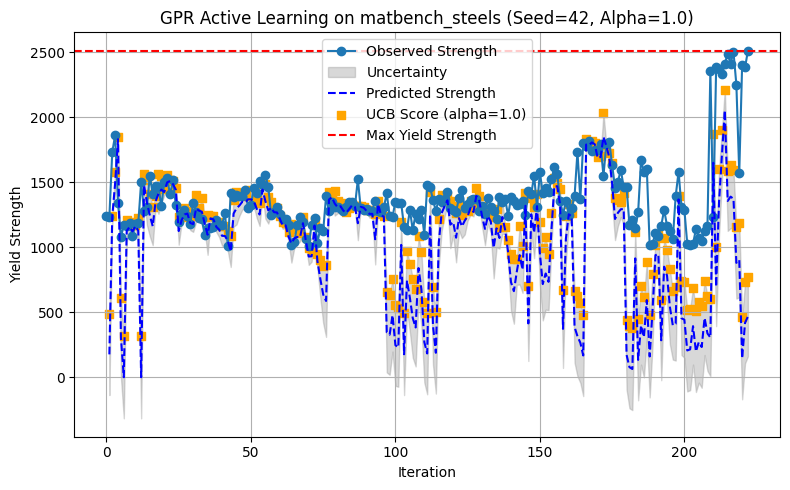

In [2]:
data=pd.read_csv(R'c:\Users\rafae\OneDrive\Imágenes\Documentos\PhDToronto\HongChenProject\steels_yield_report.csv')
run_gpr_experiment_matbench_steels(data)

In [30]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.gaussian_process import GaussianProcessRegressor
from sklearn.gaussian_process.kernels import RBF, ConstantKernel as C, WhiteKernel
from sklearn.metrics import mean_squared_error
from sklearn.preprocessing import StandardScaler
import logging


def run_gpr_experiment_matbench_steels(data_grouped, initial_train_point=1, alpha=1.0, xi=0.01, random_seed=42):
    from sklearn.preprocessing import StandardScaler
    import matplotlib.pyplot as plt
    import pandas as pd
    import numpy as np
    import random




    
    #Change this if matminer is not used from composition_original to composition 
    #feature_cols = [col for col in data_grouped.columns if col not in ['composition_original','yield strength','Report', 'Report with output', 'Formatted_Parameters']]
    #feature_cols = feature_cols.select_dtypes(include=[np.number])
    #X_df = data_grouped.drop(columns=['composition_original','yield strength','Report', 'Report with output', 'Formatted_Parameters'], errors='ignore')

    X_df = data_grouped.drop(columns=['composition_original','yield strength','Report', 'Report with output', 'Formatted_Parameters'], errors='ignore').select_dtypes(include=[np.number]).iloc[:, 14:]
    # Step 2: Keep only numeric columns
    #X_df = X_df.select_dtypes(include=[np.number])

    # Step 3: Convert to NumPy array
    X = X_df.values

    
    
    #X = data_grouped[feature_cols].values
    y = data_grouped['yield strength'].values
    max_strength = y.max()

    scaler = StandardScaler()
    X_normalized = scaler.fit_transform(X)

    random.seed(random_seed)
    initial_idx = random.choice(list(range(len(X))))
    X_train_ucb = X_normalized[[initial_idx]]
    y_train_ucb = np.array([y[initial_idx]])
    X_train_ei = X_train_ucb.copy()
    y_train_ei = y_train_ucb.copy()

    from sklearn.gaussian_process.kernels import RBF, WhiteKernel, ConstantKernel as C
    from scipy.stats import norm

    class ActiveLearningUCB:
        def __init__(self, kernel=None, alpha=1.0, random_state=42):
            self.alpha = alpha
            self.kernel = kernel if kernel else (
                C(1.0, (1e-5, 1e5)) * RBF(length_scale=1.0, length_scale_bounds=(1e-3, 1e3)) +
                WhiteKernel(noise_level=1e-3, noise_level_bounds=(1e-6, 1e1))
            )
            self.model = GaussianProcessRegressor(kernel=self.kernel, n_restarts_optimizer=10, random_state=random_state)

        def update_model(self, X_train, y_train):
            self.model.fit(X_train, y_train)

        def select_next_point(self, X_candidates):
            mean, std = self.model.predict(X_candidates, return_std=True)
            ucb = mean + self.alpha * std
            return np.argmax(ucb), ucb, mean, std

    class ActiveLearningEI:
        def __init__(self, kernel=None, xi=0.01, random_state=42):
            self.xi = xi
            self.kernel = kernel if kernel else (
                C(1.0, (1e-5, 1e5)) * RBF(length_scale=1.0, length_scale_bounds=(1e-3, 1e3)) +
                WhiteKernel(noise_level=1e-3, noise_level_bounds=(1e-6, 1e1))
            )
            self.model = GaussianProcessRegressor(kernel=self.kernel, n_restarts_optimizer=10, random_state=random_state)

        def update_model(self, X_train, y_train):
            self.model.fit(X_train, y_train)

        def select_next_point(self, X_candidates):
            mean, std = self.model.predict(X_candidates, return_std=True)
            std = np.maximum(std, 1e-9)
            y_best = np.max(self.model.y_train_)
            improvement = mean - y_best - self.xi
            Z = improvement / std
            ei = improvement * norm.cdf(Z) + std * norm.pdf(Z)
            ei[std == 0.0] = 0.0
            return np.argmax(ei), ei, mean, std

    model_ucb = ActiveLearningUCB(alpha=alpha, random_state=random_seed)
    model_ei = ActiveLearningEI(xi=xi, random_state=random_seed)
    model_ucb.update_model(X_train_ucb, y_train_ucb)
    model_ei.update_model(X_train_ei, y_train_ei)

    selected_ucb, selected_ei = [initial_idx], [initial_idx]
    obs_ucb, obs_ei = [y[initial_idx]], [y[initial_idx]]



    mean_predictions_ucb = []
    mean_predictions_ei=[]
    std_predictions_ucb=[]
    std_predictions_ei=[]
    iteration_indices = [0]


    for i in range(len(X) - 1):
        available = list(set(range(len(X))) - set(selected_ucb + selected_ei))
        if not available:
            break

        X_candidates = X_normalized[available]

        idx_ucb, ucb_scores, mean_ucb, std_ucb = model_ucb.select_next_point(X_candidates)
        next_idx_ucb = available[idx_ucb]
        selected_ucb.append(next_idx_ucb)
        obs_ucb.append(y[next_idx_ucb])
        X_train_ucb = np.vstack([X_train_ucb, X_normalized[[next_idx_ucb]]])
        y_train_ucb = np.append(y_train_ucb, y[next_idx_ucb])
        model_ucb.update_model(X_train_ucb, y_train_ucb)

        idx_ei, ei_scores, mean_ei, std_ei = model_ei.select_next_point(X_candidates)
        next_idx_ei = available[idx_ei]
        selected_ei.append(next_idx_ei)
        obs_ei.append(y[next_idx_ei])
        X_train_ei = np.vstack([X_train_ei, X_normalized[[next_idx_ei]]])
        y_train_ei = np.append(y_train_ei, y[next_idx_ei])


        
    
        mean_predictions_ei.append(mean_ei[idx_ei])
        mean_predictions_ucb.append(mean_ucb[idx_ucb])
        std_predictions_ei.append(std_ei[idx_ei])
        std_predictions_ucb.append(std_ucb[idx_ucb])

        #kernel_params.append(str(model.model.kernel_))

        model_ei.update_model(X_train_ei, y_train_ei)
        iteration_indices.append(i+1)

        if y[next_idx_ucb] >= max_strength or y[next_idx_ei] >= max_strength:
            print(f"Stopping early at iteration {i+1} - Max yield strength found.")
            break

    # Plot results
    plt.figure(figsize=(10, 6))
    plt.plot(range(len(obs_ucb)), obs_ucb, marker='o', label=f" Observed with UCB (alpha={alpha})")
    plt.plot(range(len(obs_ei)), obs_ei, marker='s', label=f"Observed with Expected Improvement (xi={xi})")
    plt.fill_between(iteration_indices[1:],
                     np.array(mean_predictions_ei) - np.array(std_predictions_ei),
                     np.array(mean_predictions_ei) + np.array(std_predictions_ei),
                     color="blue", alpha=0.3, label="Uncertainty EI")
    plt.plot(iteration_indices[1:], mean_predictions_ei, linestyle='--', color="blue", label="Predicted Strength using EI")


    plt.fill_between(iteration_indices[1:],
                     np.array(mean_predictions_ucb) - np.array(std_predictions_ucb),
                     np.array(mean_predictions_ucb) + np.array(std_predictions_ucb),
                     color="gray", alpha=0.3, label="Uncertainty UCB")
    plt.plot(iteration_indices[1:], mean_predictions_ucb, linestyle='--', color="gray", label="Predicted Strength using UCB")

    plt.axhline(max_strength, color='r', linestyle='--', label='Max Yield Strength')
    plt.xlabel("Iteration")
    plt.ylabel("Yield Strength")
    plt.title(f"Comparison of UCB and EI for Active Learning (Random seed = {random_seed})")

    plt.legend()
    plt.grid(True)
    plt.tight_layout()
    plt.show()


In [10]:
data=pd.read_csv('steels_yield_report_featurized.csv')
#run_gpr_experiment_matbench_steels(data)

In [28]:
data.drop(columns=['composition_original','yield strength','Report', 'Report with output', 'Formatted_Parameters'], errors='ignore').select_dtypes(include=[np.number]).iloc[:, 14:]#.columns: (print(i))


,MagpieData mean Number,MagpieData avg_dev Number,MagpieData minimum Number,MagpieData maximum Number,MagpieData range Number,MagpieData mean MendeleevNumber,MagpieData avg_dev MendeleevNumber,MagpieData minimum MendeleevNumber,MagpieData maximum MendeleevNumber,MagpieData range MendeleevNumber,...,MagpieData mean GSbandgap,MagpieData avg_dev GSbandgap,MagpieData minimum GSbandgap,MagpieData maximum GSbandgap,MagpieData range GSbandgap,MagpieData mean GSmagmom,MagpieData avg_dev GSmagmom,MagpieData minimum GSmagmom,MagpieData maximum GSmagmom,MagpieData range GSmagmom
0,26.037332,0.747303,6.0,42.0,36.0,54.987034,1.510824,43.0,78.0,35.0,...,0.005720,0.011407,0.0,4.496,4.496,1.678393,0.663510,0.0,2.110663,2.110663
1,26.077205,1.194414,6.0,42.0,36.0,54.546120,2.106785,46.0,82.0,36.0,...,0.046862,0.092813,0.0,6.437,6.437,1.598606,0.663674,0.0,2.110663,2.110663
2,25.522145,1.459088,6.0,42.0,36.0,55.463031,2.493353,46.0,78.0,32.0,...,0.063912,0.122895,0.0,4.496,4.496,1.633977,0.645456,0.0,2.110663,2.110663
3,26.118152,1.128467,6.0,42.0,36.0,54.482322,1.971494,46.0,78.0,32.0,...,0.031855,0.063247,0.0,4.496,4.496,1.632274,0.649702,0.0,2.110663,2.110663
4,25.785737,1.099577,6.0,42.0,36.0,55.118020,1.923317,46.0,78.0,32.0,...,0.049437,0.096960,0.0,4.496,4.496,1.656032,0.603710,0.0,2.110663,2.110663
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
307,25.772779,1.108446,6.0,42.0,36.0,55.036197,1.806416,43.0,78.0,35.0,...,0.008425,0.016816,0.0,4.496,4.496,1.632027,0.718927,0.0,2.110663,2.110663
308,25.765991,1.084443,6.0,42.0,36.0,55.053385,1.816880,46.0,78.0,32.0,...,0.049113,0.096365,0.0,4.496,4.496,1.667951,0.605175,0.0,2.110663,2.110663
309,26.466661,0.758686,6.0,42.0,36.0,56.233318,1.927879,43.0,78.0,35.0,...,0.004412,0.008813,0.0,4.496,4.496,1.788803,0.450191,0.0,2.110663,2.110663
310,26.240066,0.990594,6.0,42.0,36.0,55.517465,1.754313,43.0,78.0,35.0,...,0.002883,0.005757,0.0,4.496,4.496,1.754214,0.569117,0.0,2.110663,2.110663


In [ ]:
from matminer.featurizers.composition import ElementProperty
from matminer.featurizers.conversions import StrToComposition



# rename composition to composition_original
df = data.rename(columns={'composition': 'composition_original'})

# Convert Formula string to composition
featurized_data = StrToComposition().featurize_dataframe(df, "composition_original")

# Featurized the data based on the composition using ElementProperty (structural properties)
features = ["Number", "MendeleevNumber", "AtomicWeight", "MeltingT", "Column", "Row", 
"CovalentRadius", "Electronegativity", "NsValence", "NpValence", "NdValence", "NfValence", "NValence", 
"NsUnfilled", "NpUnfilled", "NdUnfilled", "NfUnfilled", "NUnfilled","GSvolume_pa", "GSb", 
"GSmagmom"]
stats = ["mean", "avg_dev", "minimum", "maximum", "range"]
featurized_data = ElementProperty('magpie', features, stats).featurize_dataframe(featurized_data, "composition")

df = featurized_data



StrToComposition:   0%|          | 0/312 [00:00<?, ?it/s]

ElementProperty: 100%|██████████| 312/312 [00:05<00:00, 53.88it/s] 


In [5]:
print(df.keys)

<bound method NDFrame.keys of                                   composition_original  yield strength     Fe  \
0    Fe0.768C0.000931Mn0.00244Si0.00199Cr0.110Ni0.0...          1167.2  0.768   
1    Fe0.648C0.00751Mn0.000103Si0.000201Cr0.158Ni0....          1502.0  0.648   
2    Fe0.677C0.00916Mn0.000100Si0.0294Cr0.134Ni0.00...          1382.2  0.677   
3    Fe0.679C0.00705Mn0.000103Si0.000201Cr0.153Ni0....          1341.7  0.679   
4    Fe0.664C0.00926Mn0.000101Si0.0101Cr0.134Ni0.00...          1322.1  0.664   
..                                                 ...             ...    ...   
307  Fe0.751C0.00184Mn0.000101Si0.000197Cr0.133Ni0....          1344.0  0.751   
308  Fe0.683C0.00925Mn0.000202Si0.00969Cr0.134Ni0.0...          1258.6  0.683   
309  Fe0.699C0.000946Mn0.000103Si0.000202Cr0.000109...          1212.0  0.699   
310  Fe0.798C0.000469Mn0.000820Si0.00100Cr0.0504Ni0...          1390.4  0.798   
311  Fe0.696C0.00925Mn0.000101Si0.000198Cr0.148Ni0....          1376.7  0.696  

In [ ]:
print(type(df))

<class 'pandas.core.frame.DataFrame'>


In [10]:
print(df.dtypes)

composition_original            object
yield strength                 float64
Fe                             float64
C                              float64
Mn                             float64
                                ...   
MagpieData mean GSmagmom       float64
MagpieData avg_dev GSmagmom    float64
MagpieData minimum GSmagmom    float64
MagpieData maximum GSmagmom    float64
MagpieData range GSmagmom      float64
Length: 125, dtype: object


c:\Users\wang9\.conda\envs\py38\lib\site-packages\sklearn\gaussian_process\kernels.py:430: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__k1__constant_value is close to the specified upper bound 100000.0. Increasing the bound and calling fit again may find a better value.
  warnings.warn(
c:\Users\wang9\.conda\envs\py38\lib\site-packages\sklearn\gaussian_process\kernels.py:430: ConvergenceWarning: The optimal value found for dimension 0 of parameter k2__noise_level is close to the specified upper bound 10.0. Increasing the bound and calling fit again may find a better value.
  warnings.warn(
c:\Users\wang9\.conda\envs\py38\lib\site-packages\sklearn\gaussian_process\kernels.py:430: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__k1__constant_value is close to the specified upper bound 100000.0. Increasing the bound and calling fit again may find a better value.
  warnings.warn(
c:\Users\wang9\.conda\envs\py38\lib\site-packages\s

Stopping early at iteration 12 - Max yield strength found.


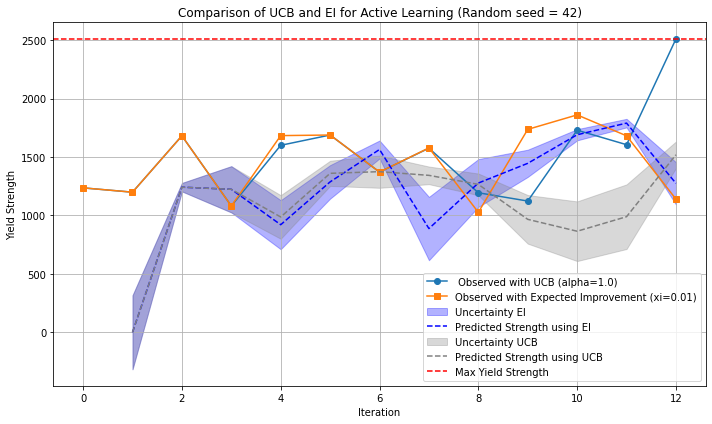

c:\Users\wang9\.conda\envs\py38\lib\site-packages\sklearn\gaussian_process\kernels.py:430: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__k1__constant_value is close to the specified upper bound 100000.0. Increasing the bound and calling fit again may find a better value.
  warnings.warn(
c:\Users\wang9\.conda\envs\py38\lib\site-packages\sklearn\gaussian_process\kernels.py:430: ConvergenceWarning: The optimal value found for dimension 0 of parameter k2__noise_level is close to the specified upper bound 10.0. Increasing the bound and calling fit again may find a better value.
  warnings.warn(
c:\Users\wang9\.conda\envs\py38\lib\site-packages\sklearn\gaussian_process\kernels.py:430: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__k1__constant_value is close to the specified upper bound 100000.0. Increasing the bound and calling fit again may find a better value.
  warnings.warn(
c:\Users\wang9\.conda\envs\py38\lib\site-packages\s

Stopping early at iteration 119 - Max yield strength found.


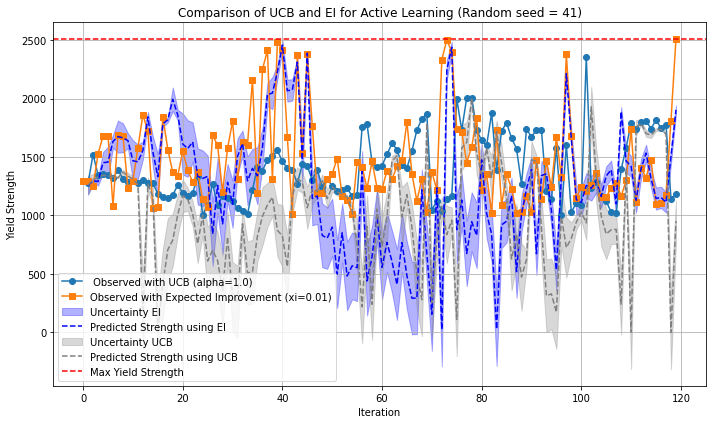

c:\Users\wang9\.conda\envs\py38\lib\site-packages\sklearn\gaussian_process\kernels.py:430: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__k1__constant_value is close to the specified upper bound 100000.0. Increasing the bound and calling fit again may find a better value.
  warnings.warn(
c:\Users\wang9\.conda\envs\py38\lib\site-packages\sklearn\gaussian_process\kernels.py:430: ConvergenceWarning: The optimal value found for dimension 0 of parameter k2__noise_level is close to the specified upper bound 10.0. Increasing the bound and calling fit again may find a better value.
  warnings.warn(
c:\Users\wang9\.conda\envs\py38\lib\site-packages\sklearn\gaussian_process\kernels.py:430: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__k1__constant_value is close to the specified upper bound 100000.0. Increasing the bound and calling fit again may find a better value.
  warnings.warn(
c:\Users\wang9\.conda\envs\py38\lib\site-packages\s

Stopping early at iteration 43 - Max yield strength found.


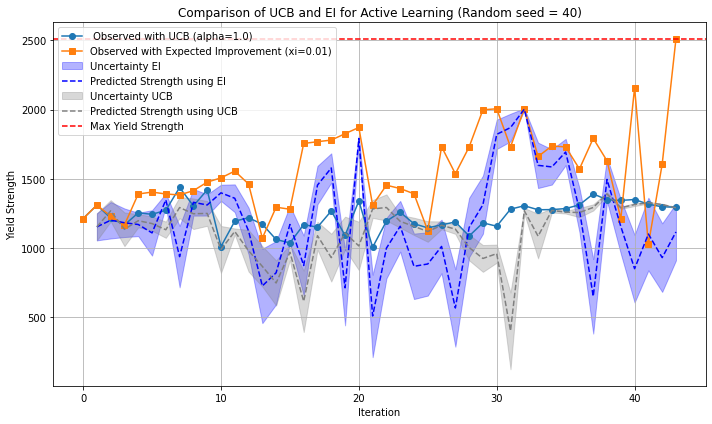

c:\Users\wang9\.conda\envs\py38\lib\site-packages\sklearn\gaussian_process\kernels.py:430: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__k1__constant_value is close to the specified upper bound 100000.0. Increasing the bound and calling fit again may find a better value.
  warnings.warn(
c:\Users\wang9\.conda\envs\py38\lib\site-packages\sklearn\gaussian_process\kernels.py:430: ConvergenceWarning: The optimal value found for dimension 0 of parameter k2__noise_level is close to the specified upper bound 10.0. Increasing the bound and calling fit again may find a better value.
  warnings.warn(
c:\Users\wang9\.conda\envs\py38\lib\site-packages\sklearn\gaussian_process\kernels.py:430: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__k1__constant_value is close to the specified upper bound 100000.0. Increasing the bound and calling fit again may find a better value.
  warnings.warn(
c:\Users\wang9\.conda\envs\py38\lib\site-packages\s

Stopping early at iteration 3 - Max yield strength found.


c:\Users\wang9\.conda\envs\py38\lib\site-packages\sklearn\gaussian_process\kernels.py:430: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__k1__constant_value is close to the specified upper bound 100000.0. Increasing the bound and calling fit again may find a better value.
  warnings.warn(
c:\Users\wang9\.conda\envs\py38\lib\site-packages\sklearn\gaussian_process\kernels.py:430: ConvergenceWarning: The optimal value found for dimension 0 of parameter k2__noise_level is close to the specified upper bound 10.0. Increasing the bound and calling fit again may find a better value.
  warnings.warn(


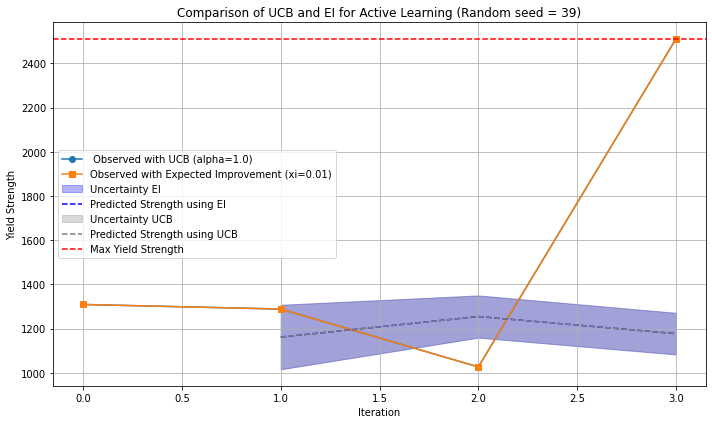

c:\Users\wang9\.conda\envs\py38\lib\site-packages\sklearn\gaussian_process\kernels.py:430: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__k1__constant_value is close to the specified upper bound 100000.0. Increasing the bound and calling fit again may find a better value.
  warnings.warn(
c:\Users\wang9\.conda\envs\py38\lib\site-packages\sklearn\gaussian_process\kernels.py:430: ConvergenceWarning: The optimal value found for dimension 0 of parameter k2__noise_level is close to the specified upper bound 10.0. Increasing the bound and calling fit again may find a better value.
  warnings.warn(
c:\Users\wang9\.conda\envs\py38\lib\site-packages\sklearn\gaussian_process\kernels.py:430: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__k1__constant_value is close to the specified upper bound 100000.0. Increasing the bound and calling fit again may find a better value.
  warnings.warn(
c:\Users\wang9\.conda\envs\py38\lib\site-packages\s

Stopping early at iteration 10 - Max yield strength found.


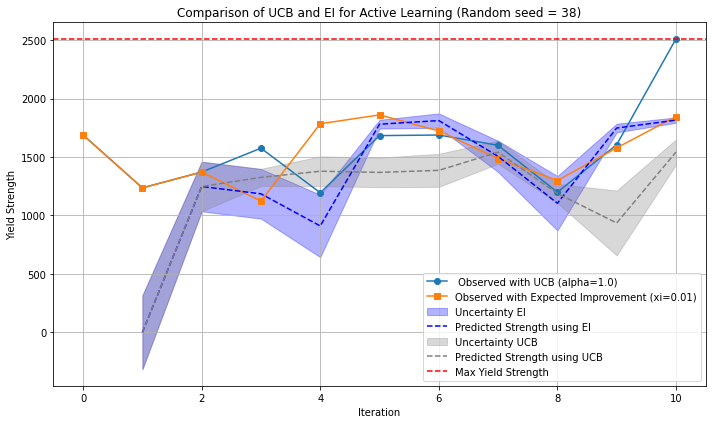

In [31]:
run_gpr_experiment_matbench_steels(df,random_seed=42 )
run_gpr_experiment_matbench_steels(df,random_seed=41 )
run_gpr_experiment_matbench_steels(df,random_seed=40 )
run_gpr_experiment_matbench_steels(df,random_seed=39 )
run_gpr_experiment_matbench_steels(df,random_seed=38 )

C:\Users\rafae\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\gaussian_process\kernels.py:452: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__k1__constant_value is close to the specified upper bound 100000.0. Increasing the bound and calling fit again may find a better value.
  warnings.warn(
C:\Users\rafae\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\gaussian_process\kernels.py:452: ConvergenceWarning: The optimal value found for dimension 0 of parameter k2__noise_level is close to the specified upper bound 10.0. Increasing the bound and calling fit again may find a better value.
  warnings.warn(
C:\Users\rafae\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\gaussian_process\kernels.py:452: ConvergenceWa

Stopping early at iteration 14 - Max yield strength found.


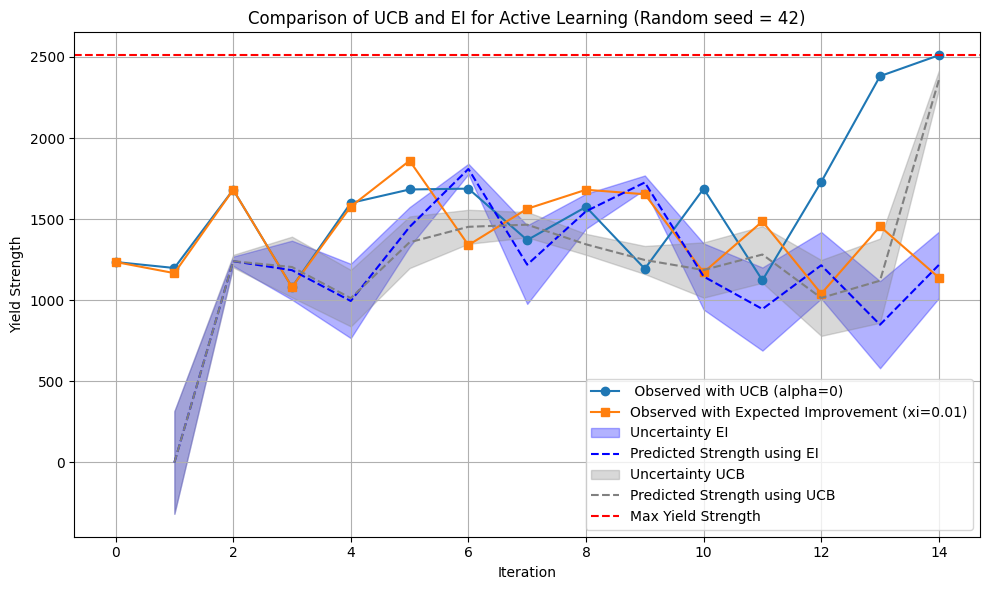

C:\Users\rafae\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\gaussian_process\kernels.py:452: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__k1__constant_value is close to the specified upper bound 100000.0. Increasing the bound and calling fit again may find a better value.
  warnings.warn(
C:\Users\rafae\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\gaussian_process\kernels.py:452: ConvergenceWarning: The optimal value found for dimension 0 of parameter k2__noise_level is close to the specified upper bound 10.0. Increasing the bound and calling fit again may find a better value.
  warnings.warn(
C:\Users\rafae\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\gaussian_process\kernels.py:452: ConvergenceWa

KeyboardInterrupt: 

In [31]:
for alpha in [0, 0.1, 0.3, 0.5, 0.8, 1, 2, 3, 4, 5]:
    for seed in [42, 41, 40, 39, 38]:
        run_gpr_experiment_matbench_steels(df, initial_train_point=1, alpha=alpha, random_seed=seed)